# Project by Lennart Wallentin, lennartwallentin@gmail.com
The main objective with this project is first of all to show that I have a broad set of skills regarding machine learning algorithms since I use Logistic Regression, XGBoost and Neural Networks in this project. The second objective is to research if a stacked generalization with a neural network (built with Keras and TensorFlow) as meta learner yields a higher AUC score than a stacked generalization with XGBoost as meta learner. The benchmark AUC score’s I use to compare against was yield from my other stacked generalization project https://github.com/lennartwallentin/passenger_satisfaction_stacking_anova hence there are similarities between these two projects but with one important distinction, in this project I show that I also have a good understanding regarding neural networks and the Keras and TensorFlow library.

In addition to that I also demonstrate:
* <b>Machine learning -</b> Use different Python libraries like Scikit-learn, XGBoost and Keras (it’s built on top of TensorFlow) to build machine learning model’s. Regarding the neural network I use Keras more flexible Functional API as a way to create the models and I also use KerasTuner together with Bayesian optimization for the hyperparameter tuning. In addition to that I describe in depth important neural network parts such as layers, activation functions (incl ReLU), batch normalization and a neural network model instantiation. <br>For all models including the standalone model’s and the stacked generalization base and meta learner model’s, I validate the model’s strength as well as approximate the model's optimal parameters. And explain the model's output in an interpretable and clear way. 


* <b>Business knowledge -</b> 
Last in my project at section <i>5.1 A higher AUC score, so what? - Business context</i>. I bring up something many data scientists sometimes struggle with, describing their findings in a business friendly way to their stakeholders. In that section I explain how changes to the AUC score also affect other evaluation metrics and I use the false negative rate (FNR) and how changes in FNR affects a core business metric regarding the number of satisfied or neutral/dissatisfied airline passengers.

This is the structure of this project:
1. Data preparation
        1.1. Data presentation
        1.2. Handling NA and missing values
        1.3. Data types and Correlation
            1.3.1. Pearson correlation for the numerical features
            1.3.2. Cramer's V association for the categorical feature
        1.4. Histograms, Boxplots Outliers and Unique values
            1.4.1. Unique values categorical features
        1.5. Encoding and create train and test sets
2. GLM - Logistic regression
        2.1. Recursive Feature Elimination (RFE)
            2.1.1. Compare AUC, Logistic regression 
3. XGBoost
            3.0.1. Feature importance plot
            3.0.2. Gain score and feature selection
            3.0.3. Compare AUC, XGBoost
        3.1. XGBoost hyperparameter tuning with Bayesian optimization
            3.1.1. Compare AUC, XGBoost hyperparameter tuned
4. Stacking 
        4.1. Stacking Base Learner - GLM - Logistic Regression
            4.1.1 Recursive Feature Elimination (RFE) Base learner - Logistic regression
            4.1.2. Compare AUC, Base learner - Logistic regression
        4.2. Stacking Base Learner - XGBoost
            4.2.1. Compare AUC, Base learner - XGBoost
            4.2.2. XGBoost Base learner hyperparameter tuning with Bayesian optimization
            4.2.3. Compare AUC, Base learner - XGBoost hyperparameter tuned
        4.3 Stacking Meta Learner - Neural network (Keras and TensorFlow)
            4.3.1. Compare AUC, Meta learner - Neural network
            4.3.2. Neural network Meta learner hyperparameter tuning with KerasTuner Bayesian optimization
            4.3.3. Compare AUC, Meta learner - Neural network hyperparameter tuned
5. Conclusion -  Comparing AUC
        5.1 A higher AUC score, so what? - Business context

# 1. Data preparation

## 1.1 Data presentation
The data is originally downloaded from the website kaggle.com as an xlsx file which I in turn transform to an csv file to speed up the transformation to an pandas DataFrame. I also fix the feature names in the csv file so that every feature name starts with a capital letter. 

The dataset contains information about flights with an unnamed north american airline company and has 23 features including the target variable ‘Satisfaction’. Most of the features are from rating questions such as rate the food and drink on the plane or the inflight entertainment but it does also include numerical features such as flight distance. When I convert the data to a pandas DataFrame I give the DataFrame the name df.  

Links: 

Dataset - satisfaction.xlsx - https://www.kaggle.com/johndddddd/customer-satisfaction 

In [1]:
# import necessary packages 
import pandas as pd
import numpy as np
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-dark')
from sklearn import preprocessing
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV

import xgboost as xgb
from bayes_opt import BayesianOptimization

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import keras_tuner as kt

In [2]:
# import data and print the first 10 rows
df = pd.read_csv('https://raw.githubusercontent.com/lennartwallentin/neural_network_stacked_generalization_xgboost_glm/main/data_neural_network_stacked_generalization_xgboost_glm_lennart_wallentin.csv')
df.head(10)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction
0,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,3,3,0,3,5,3,2,0,0.0,satisfied
1,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,3,4,4,4,2,3,2,310,305.0,satisfied
2,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,3,3,4,4,4,2,0,0.0,satisfied
3,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,1,1,0,1,4,1,3,0,0.0,satisfied
4,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,2,2,0,2,4,2,5,0,0.0,satisfied
5,Male,Loyal Customer,30,Personal Travel,Eco,1894,0,0,0,3,...,2,5,4,5,5,4,2,0,0.0,satisfied
6,Female,Loyal Customer,66,Personal Travel,Eco,227,0,0,0,3,...,5,5,0,5,5,5,3,17,15.0,satisfied
7,Male,Loyal Customer,10,Personal Travel,Eco,1812,0,0,0,3,...,2,3,3,4,5,4,2,0,0.0,satisfied
8,Female,Loyal Customer,56,Personal Travel,Business,73,0,0,0,3,...,4,4,0,1,5,4,4,0,0.0,satisfied
9,Male,Loyal Customer,22,Personal Travel,Eco,1556,0,0,0,3,...,2,2,4,5,3,4,2,30,26.0,satisfied


In [3]:
# shape of data frame (df)
df.shape

(129880, 23)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Seat comfort                       129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Food and drink                     129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Inflight wifi service              129880 non-null  int64  
 11  Inflight entertainment             1298

### Comment - Non-Null Count
df.info() shows that one feature ‘Arrival Delay in Minutes’ have some Non_null i.e. missing values in it’s column. 

A more thorough look into missing values in the df will be conducted further down the notebook.   


Text(0, 0.5, 'Count')

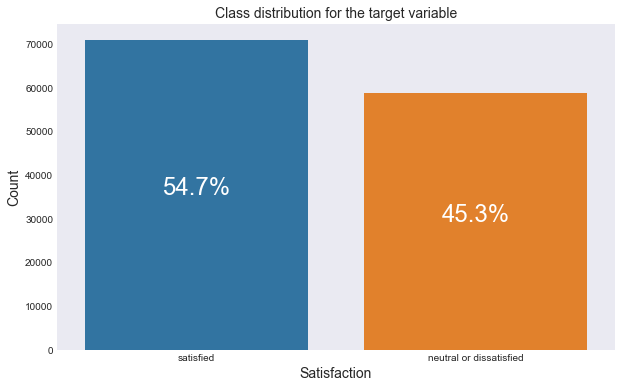

In [5]:
# plot the class distribution for the target variable
fig = plt.figure(figsize=(10, 6))
ax = sns.countplot(x='Satisfaction', data=df)
ax.set_title('Class distribution for the target variable', size=14)

for p in ax.patches:
    ax.text(x = p.get_x() + p.get_width()/2, y = p.get_height()/2, # set position (data cordinates) for the text 
            s = f"{np.round(p.get_height()/len(df)*100, 1)}%", # the text
            horizontalalignment ='center', size=24, color='white')
    
ax.set_xlabel('Satisfaction', size=14)
ax.set_ylabel('Count', size=14)

### Comment - Class distribution
The binary target variable is not divided evenly 50/50 but it’s far from being considered an extreme skewed class distribution that potentially would have required me to balance the dataset to get some value from the minority class

## 1.2 Handling NA and missing values

In [6]:
# a function that for each column in the dataset checks if a variable contains a NA-value, 
# counts number of observations with NA-values in the variable, 
# and finally calculates the percentage of NA-values in that variable. 
# If the data contains no NA-values then that information is printed out

def describe_isna_values(data):
    cc = 0      # column counter
    cnac = 0    # column with isna() values counter
    for i in data.columns:        
        missing = data[i].isna()
        num_missing = missing.sum()
        pct_missing = missing.mean()*100 
        cc = cc + 1
    
        if num_missing > 0:
            print(f'Column with NA-value: {i:25} {num_missing:8} NA-values {pct_missing:8.3f}% of the values is NA-values')
            cnac = cnac + 1
        
        if cc == len(data.columns) and cnac == 0:
            print(f'No NA-values (checked {cc} columns out of {len(data.columns)} columns)')

In [7]:
describe_isna_values(df)

Column with NA-value: Arrival Delay in Minutes       393 NA-values    0.303% of the values is NA-values


In [8]:
# drop rows with NA-values (from the 'Arrival Delay in Minutes'-column)
df.dropna(inplace=True)

In [9]:
describe_isna_values(df)

No NA-values (checked 23 columns out of 23 columns)


### Comment - Missing values
In the data description at kaggle.com it says that for the feature “‘Inflight wifi service' 0 = Not Applicable” i.e. 0 = NA. But it’s not stated with certainty for the other categorical features with answers from rating questions.

I interpret it that rating questions in this dataset have given the respondent the ability to answer between 1-5 and that 0 should be treated as an NA-value. 

I base that on:
* In the data description, the rating question ‘Inflight wifi service’ it is stated that 0 = Not Applicable
* ‘Baggage handling’ is also a rating question but does only have 1-5 as options to answer 
* When making an histogram about the different rating question features, it’s clear that the answer 0 has a considerably smaller frequency count than the other values in the feature. 0 is actually the minimum value in every rating question feature in the df. 


In [10]:
# a list of features names that contains rating questions answers 
rating_questions=['Inflight wifi service', 'Online support', 'Departure/Arrival time convenient', 'Ease of Online booking',
'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness']

In [11]:
# the range is (at most) 0 to 5, use transpose (T) on the describe method to easier see the min and max for each column. 
df.loc[:,rating_questions].describe().T

,count,mean,std,min,25%,50%,75%,max
Inflight wifi service,129487.0,3.249160,1.318765,0.0,2.0,3.0,4.0,5.0
Online support,129487.0,3.519967,1.306326,0.0,3.0,4.0,5.0,5.0
Departure/Arrival time convenient,129487.0,2.990277,1.527183,0.0,2.0,3.0,4.0,5.0
Ease of Online booking,129487.0,3.472171,1.305573,0.0,2.0,4.0,5.0,5.0
Gate location,129487.0,2.990377,1.305917,0.0,2.0,3.0,4.0,5.0
Food and drink,129487.0,2.852024,1.443587,0.0,2.0,3.0,4.0,5.0
Online boarding,129487.0,3.352545,1.298624,0.0,2.0,4.0,4.0,5.0
Seat comfort,129487.0,2.838586,1.392873,0.0,2.0,3.0,4.0,5.0
Inflight entertainment,129487.0,3.383745,1.345959,0.0,2.0,4.0,4.0,5.0
On-board service,129487.0,3.465143,1.270755,0.0,3.0,4.0,4.0,5.0


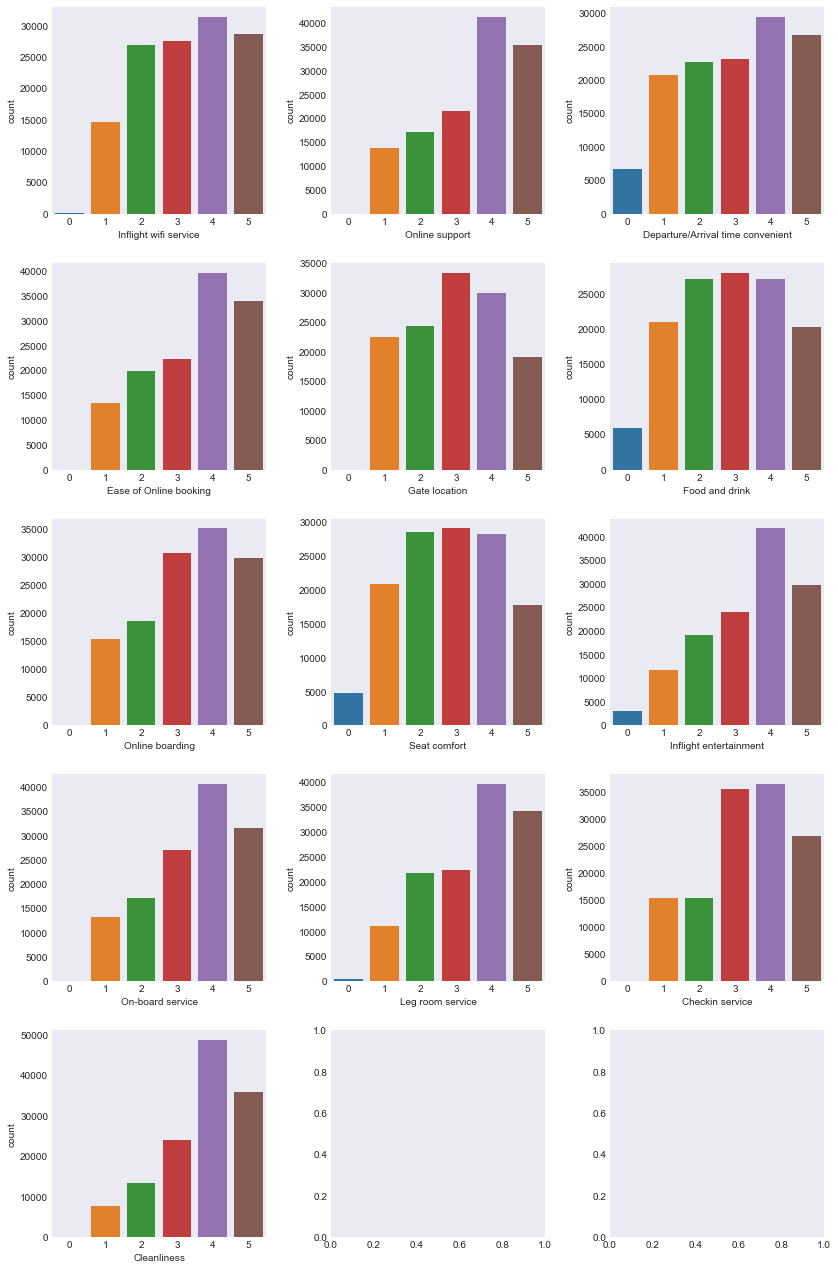

In [12]:
# a list with the features names that contains answers from rating questions that have a 0 as an answer (that's every feature in rating_questions except 'Baggage handling')
# plot an histogram of each feature

rating_questions_zero=['Inflight wifi service', 'Online support', 'Departure/Arrival time convenient', 'Ease of Online booking',
'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment',
'On-board service', 'Leg room service', 'Checkin service', 'Cleanliness']

fig, ax2 = plt.subplots(nrows=5, ncols=3, figsize=(12, 18))
ax2 = ax2.reshape(-1)

for i, col in enumerate(rating_questions_zero):
  sns.countplot(x=df[col], ax=ax2[i])

fig.tight_layout(pad=2.0)

In [13]:
# 0 was the minimum value in every histogram. 
# With that information it’s easy to show the number of times the value 0 appeared in each feature 
for i in rating_questions_zero:
    print(f'{i:33} {df[i].value_counts().min():6}')

Inflight wifi service                130
Online support                         1
Departure/Arrival time convenient   6644
Ease of Online booking                18
Gate location                          2
Food and drink                      5922
Online boarding                       14
Seat comfort                        4781
Inflight entertainment              2968
On-board service                       5
Leg room service                     442
Checkin service                        1
Cleanliness                            5


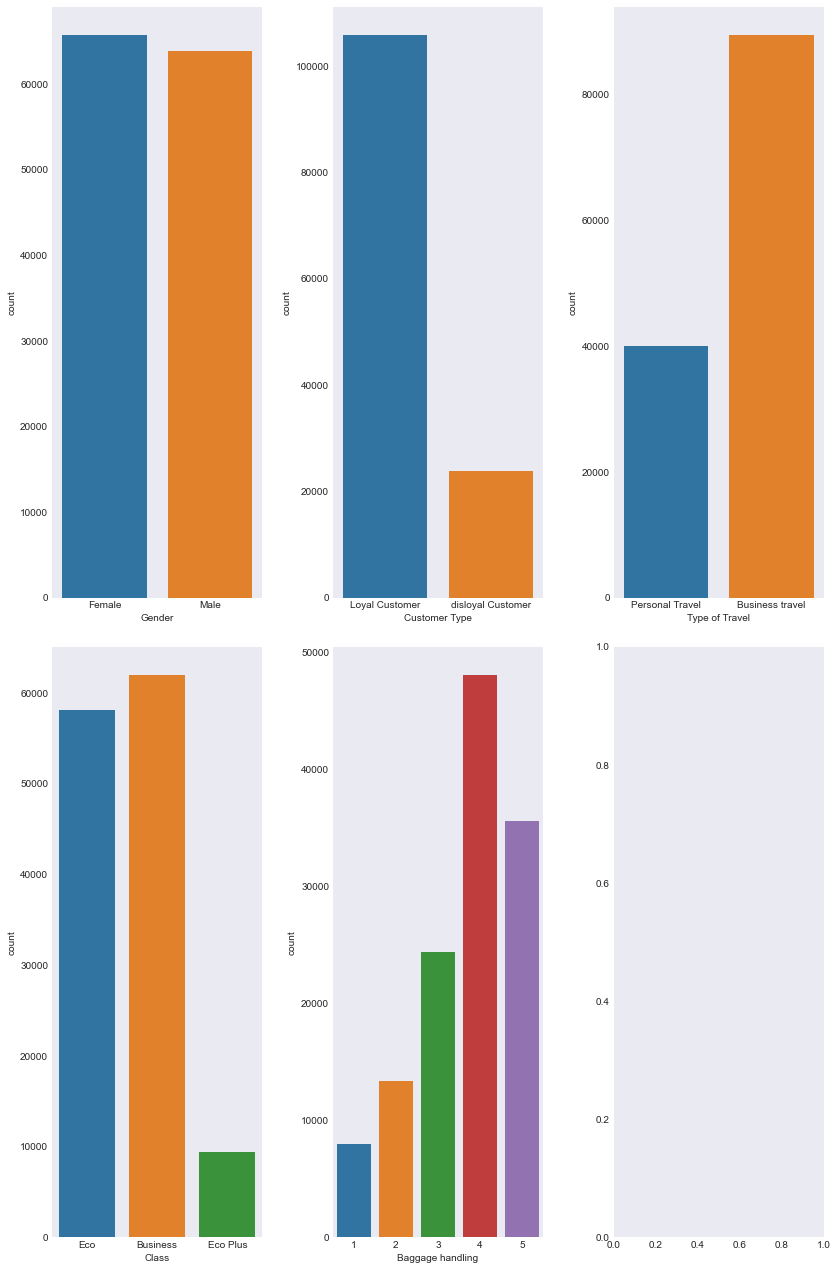

In [14]:
# Check that no other categorical feature have a 0 as observation name
other_categorical=['Gender', 'Customer Type','Type of Travel', 'Class', 'Baggage handling']
fig, ax3 = plt.subplots(nrows=2, ncols=3, figsize=(12, 18))
ax3 = ax3.reshape(-1)
for i, col in enumerate(other_categorical):
  sns.countplot(x=df[col], ax=ax3[i])
fig.tight_layout(pad=2.0)

In [15]:
# subset the features with 0-values 
convert_nan_values = df.loc[:,rating_questions_zero]
# convert 0 to NaN
convert_nan_values = convert_nan_values[convert_nan_values != 0]

# drop the old features with 0-values
df = df.drop(convert_nan_values, axis=1)
# concatenate the new features with Nan-values instead of 0-values
df = pd.concat([df,convert_nan_values], axis = 1)

In [16]:
describe_isna_values(df)

Column with NA-value: Inflight wifi service          130 NA-values    0.100% of the values is NA-values
Column with NA-value: Online support                   1 NA-values    0.001% of the values is NA-values
Column with NA-value: Departure/Arrival time convenient     6644 NA-values    5.131% of the values is NA-values
Column with NA-value: Ease of Online booking          18 NA-values    0.014% of the values is NA-values
Column with NA-value: Gate location                    2 NA-values    0.002% of the values is NA-values
Column with NA-value: Food and drink                5922 NA-values    4.573% of the values is NA-values
Column with NA-value: Online boarding                 14 NA-values    0.011% of the values is NA-values
Column with NA-value: Seat comfort                  4781 NA-values    3.692% of the values is NA-values
Column with NA-value: Inflight entertainment        2968 NA-values    2.292% of the values is NA-values
Column with NA-value: On-board service                 5

In [17]:
# drop NA-values and reset index
df.dropna(inplace=True)
df = df.reset_index(drop=True)

In [18]:
describe_isna_values(df)

No NA-values (checked 23 columns out of 23 columns)


## 1.3 Data types and Correlation

Make sure that the categorical and numerical features are set to their correct data type before checking the correlation between features. 

In [19]:
# list of all the categorical feature names
categorical = ['Gender', 'Customer Type','Type of Travel', 'Class', 'Baggage handling','Inflight wifi service', 'Online support',
       'Departure/Arrival time convenient', 'Ease of Online booking','Gate location', 'Food and drink', 'Online boarding', 
       'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Checkin service', 'Cleanliness','Satisfaction']

In [20]:
# create a dataframe with only the categorical features to be used to check correlation with Cramer’s V  
df_categorical = df.loc[:,categorical].astype('object')

# set the categorical features to their correct type in the original df
for col in categorical:
    df[col] = df[col].astype('object')

In [21]:
# create a dataframe with only the numerical features to be used to check correlation with Pearson correlation coefficient
df_numeric = df.drop(df_categorical, axis=1)

### Comment - Numerical variables
The feature ‘Age’ consists of peoples age as an continuous variable but I choose to group them together to 8 discrete bins instead ('Kid','Teen','20s','30s'...'60s','Senior') and use the 8 bins in my analysis

We can also see in the histogram that ‘Flight Distance’ have some values with suspiciously low flight distance. I will look further into that in the next step of the data-preprocessing.

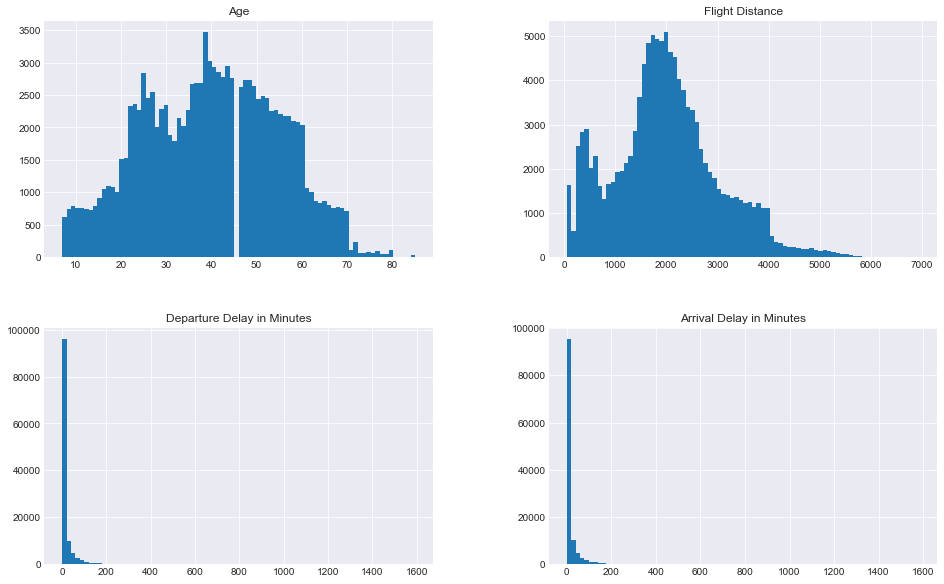

In [22]:
df_numeric.hist(bins=80, figsize=(16,10))
plt.show()

In [23]:
# group the 'Age'-feature into age groups instead of using age as a continuous variable
bins= [0,13,20,30,40,50,60,70,110]
labels = ['Kid','Teen','20s','30s','40s','50s','60s','Senior']

# create a new feature in df_categorical and df called "Age Group" and make the type an object
df_categorical['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False).astype('object')
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False).astype('object')

# drop 'Age' from df_numeric and df
df_numeric.drop('Age', axis=1, inplace=True)
df.drop('Age', axis=1, inplace=True)

### 1.3.1 Pearson correlation for the numerical features

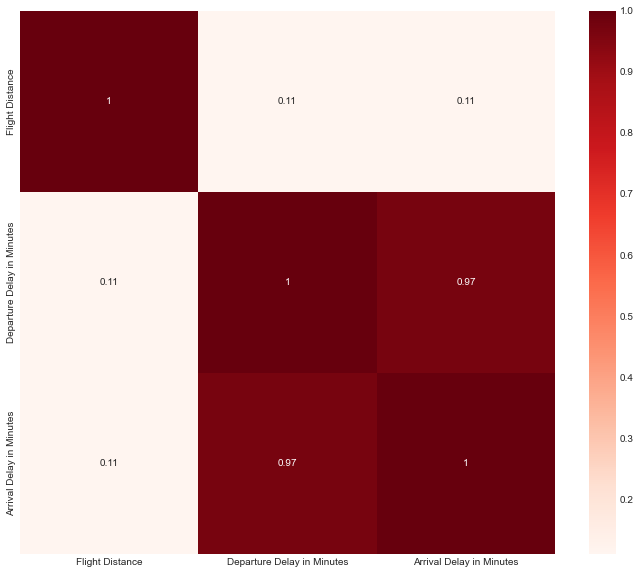

In [24]:
plt.figure(figsize=(12,10))
pearson_corr = round(df_numeric.corr(),2)
sns.heatmap(pearson_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [25]:
# to ease the sorting return absolute value from numeric_corr
pearson_corr_abs = pearson_corr.abs().unstack()
# show features with a correlation that is equal to or above 0.75
# choose < 1 to avoid printing "noise" from the diagonal line with 1's
pearson_corr_abs_sort = pearson_corr_abs[np.logical_and(pearson_corr_abs < 1, pearson_corr_abs >= 0.75)].sort_values(ascending = False)
pearson_corr_abs_sort

Departure Delay in Minutes  Arrival Delay in Minutes      0.97
Arrival Delay in Minutes    Departure Delay in Minutes    0.97
dtype: float64

### Comment - Numerical correlation
If two features have a correlation with each other that is equal to or above 0.75, delete one of the two features because they are considered to be very similar. 

In [26]:
# delete the 'Arrival Delay in Minutes' feature  
df_numeric.drop('Arrival Delay in Minutes', axis=1, inplace=True)
df.drop('Arrival Delay in Minutes', axis=1, inplace=True)

### 1.3.2 Cramer's V association for the categorical features

Pearson correlation coefficient is used for numerical features and can show both positive and negative correlation. For categorical features you don’t check the correlation instead you check the association between features. Meaning you don’t get information if the relationship between categorical features are positive or negative, just that there is a relationship/association between them. 
<br>One way to check the association for categorical features is to use the chi-squared test, that is if you only compare two features i.e. it's a 2x2 contingency table. To compare the association between more than two features the Cramer’s V is often used to explain the categorical association. Cramer’s V is based on chi-squared (it’s used to calculate Cramer's V squared phi coefficient) hence as explained regarding the difference between correlation and association Cramer’s V only shows positive association values.</br> 

With inspiration from this published article:  ‘Alternatives to P value: Confidence interval and effect size’ - https://www.researchgate.net/figure/Interpretation-of-PH-in-Chi-statistics-or-Cramers-V_tbl2_311335682 I decide to set the cut-off value for to strong association at 0.60 

In [27]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119255 entries, 0 to 119254
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   Gender                             119255 non-null  object
 1   Customer Type                      119255 non-null  object
 2   Type of Travel                     119255 non-null  object
 3   Class                              119255 non-null  object
 4   Baggage handling                   119255 non-null  object
 5   Inflight wifi service              119255 non-null  object
 6   Online support                     119255 non-null  object
 7   Departure/Arrival time convenient  119255 non-null  object
 8   Ease of Online booking             119255 non-null  object
 9   Gate location                      119255 non-null  object
 10  Food and drink                     119255 non-null  object
 11  Online boarding                    119255 non-null  

In [28]:
# label encode the categorical features
cramers_v_enc_corr = preprocessing.LabelEncoder()
cramers_v_corr_encoded = pd.DataFrame()

for i in df_categorical.columns:
  cramers_v_corr_encoded[i]=cramers_v_enc_corr.fit_transform(df_categorical[i].astype(str))

In [29]:
# a function that calculates the Cramer's V between the categorical features
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # crosstab/contingency table, displays the frequency distribution of the features
    chi2 = chi2_contingency(crosstab)[0] # chi-square test of independence of the features 
    n = np.sum(crosstab)
    phi2 = chi2 / n # calculate the phi coefficient
    r, c = crosstab.shape # number of rows and columns
    
    # bias correction, to avoid overestimate the strength of association
    phi2corr = max(0, phi2 - ((c-1)*(r-1))/(n-1)) 
    rcorr = r - ((r-1)**2)/(n-1) 
    ccorr = c - ((c-1)**2)/(n-1) 

    return np.sqrt(phi2corr / min((ccorr-1), (rcorr-1)))

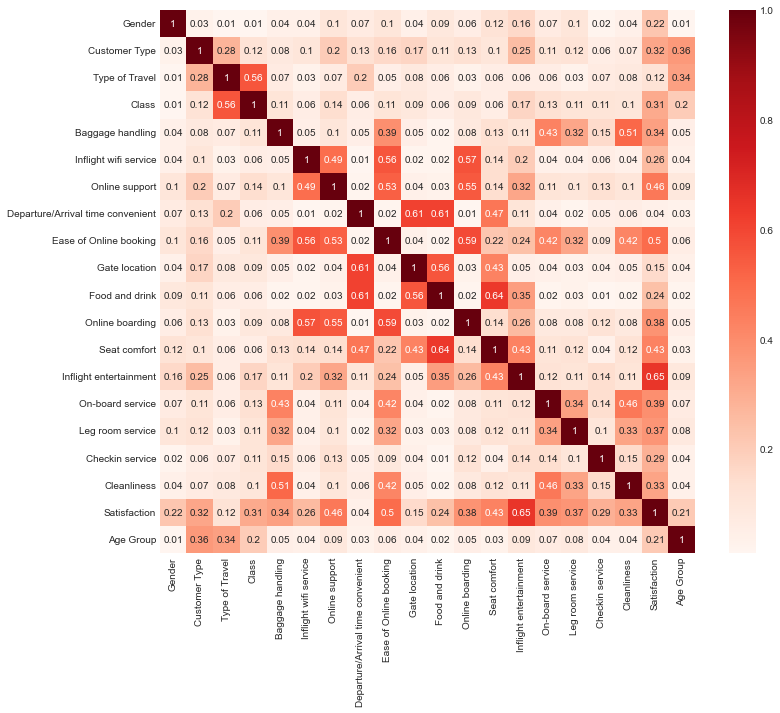

In [30]:
rows = [] # create empty list

for var1 in cramers_v_corr_encoded:
  col = [] 
  for var2 in cramers_v_corr_encoded:
    cramers_v = cramers_V(cramers_v_corr_encoded[var1], cramers_v_corr_encoded[var2]) # Cramer's V test
    col.append(round(cramers_v,2)) # append rounded value (two decimal places)  
  rows.append(col) 

# tabulating the Cramer's V   
cramers_v_corr = pd.DataFrame(np.array(rows), columns = cramers_v_corr_encoded.columns, index = cramers_v_corr_encoded.columns)

plt.figure(figsize=(12,10))
sns.heatmap(cramers_v_corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [31]:
cramers_v_corr_unstack = cramers_v_corr.unstack()
# show features with a association that is equal to or above 0.60
# choose < 1 to avoid printing "noise" from the diagonal line with 1's
cramers_v_corr_sort = cramers_v_corr_unstack[np.logical_and(cramers_v_corr_unstack < 1, cramers_v_corr_unstack >= 0.6)].sort_values(ascending = False)
cramers_v_corr_sort

Inflight entertainment             Satisfaction                         0.65
Satisfaction                       Inflight entertainment               0.65
Food and drink                     Seat comfort                         0.64
Seat comfort                       Food and drink                       0.64
Departure/Arrival time convenient  Gate location                        0.61
                                   Food and drink                       0.61
Gate location                      Departure/Arrival time convenient    0.61
Food and drink                     Departure/Arrival time convenient    0.61
dtype: float64

### Comment - Categorical association
If two features have a association with each other that is equal to or above 0.6, delete one of the two features because they are considered to be very similar. 

In [32]:
df_categorical.drop(['Inflight entertainment','Seat comfort', 'Departure/Arrival time convenient'], axis=1, inplace=True)
df.drop(['Inflight entertainment','Seat comfort', 'Departure/Arrival time convenient'], axis=1, inplace=True)

## 1.4 Histograms, Boxplots, Outliers and Unique values
I once again plot the histogram for the numerical features and also plot the boxplots and the kernel density estimation (KDE) to visualize outliers. Then I create a function that checks for extreme outliers. But I don't remove all extreme outliers instead I conclude that:
* The ‘Flight Distance’ outliers in not outliers but instead long flights, but to be able to answer all the rating questions truthfully you need to spend some time on the flight I therefore cut the minimum flight distance to 200 miles (322 kilometers) and remove all instances from the df with an ‘Flight Distance value lower than 200   
* For the ‘Departure Delay in Minutes’ feature it’s also hard to say what’s an outlier or not but I conclude that a person traveling with an airline in the US should maximum be delayed 12 hours before he/she is either in the air or rebooked on another flight. Hence I set the maximum value to 720 (12*60 minutes) and remove all instances from the df with an ‘Departure Delay in Minutes’ higher than 720  

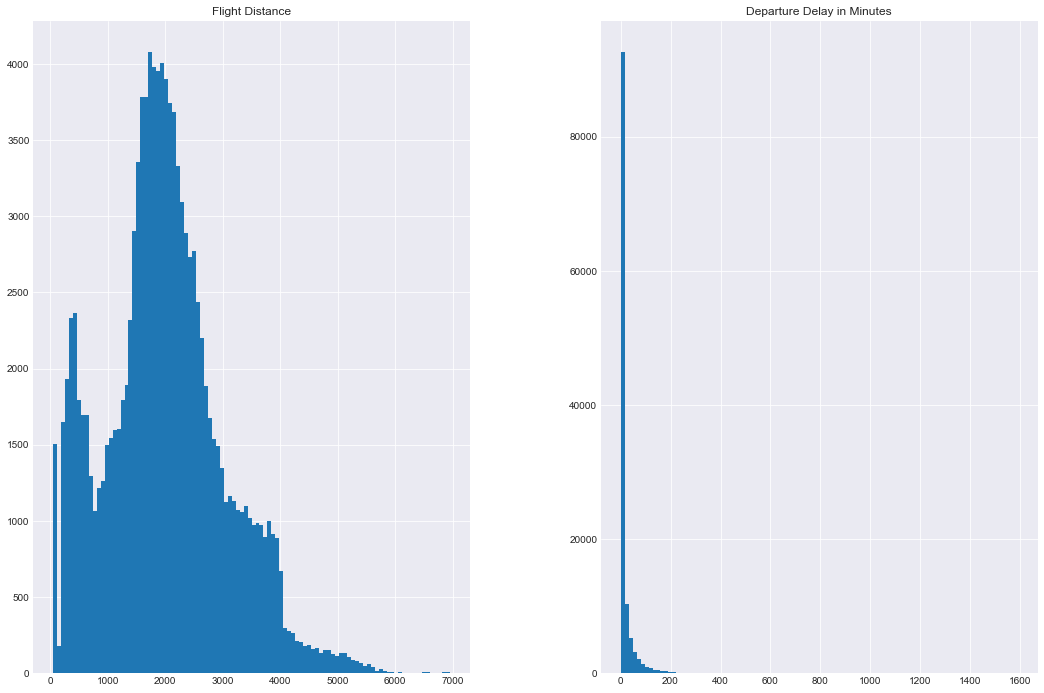

In [33]:
# plot histogram
df_numeric.hist(bins=100, figsize=(18,12))
plt.show()

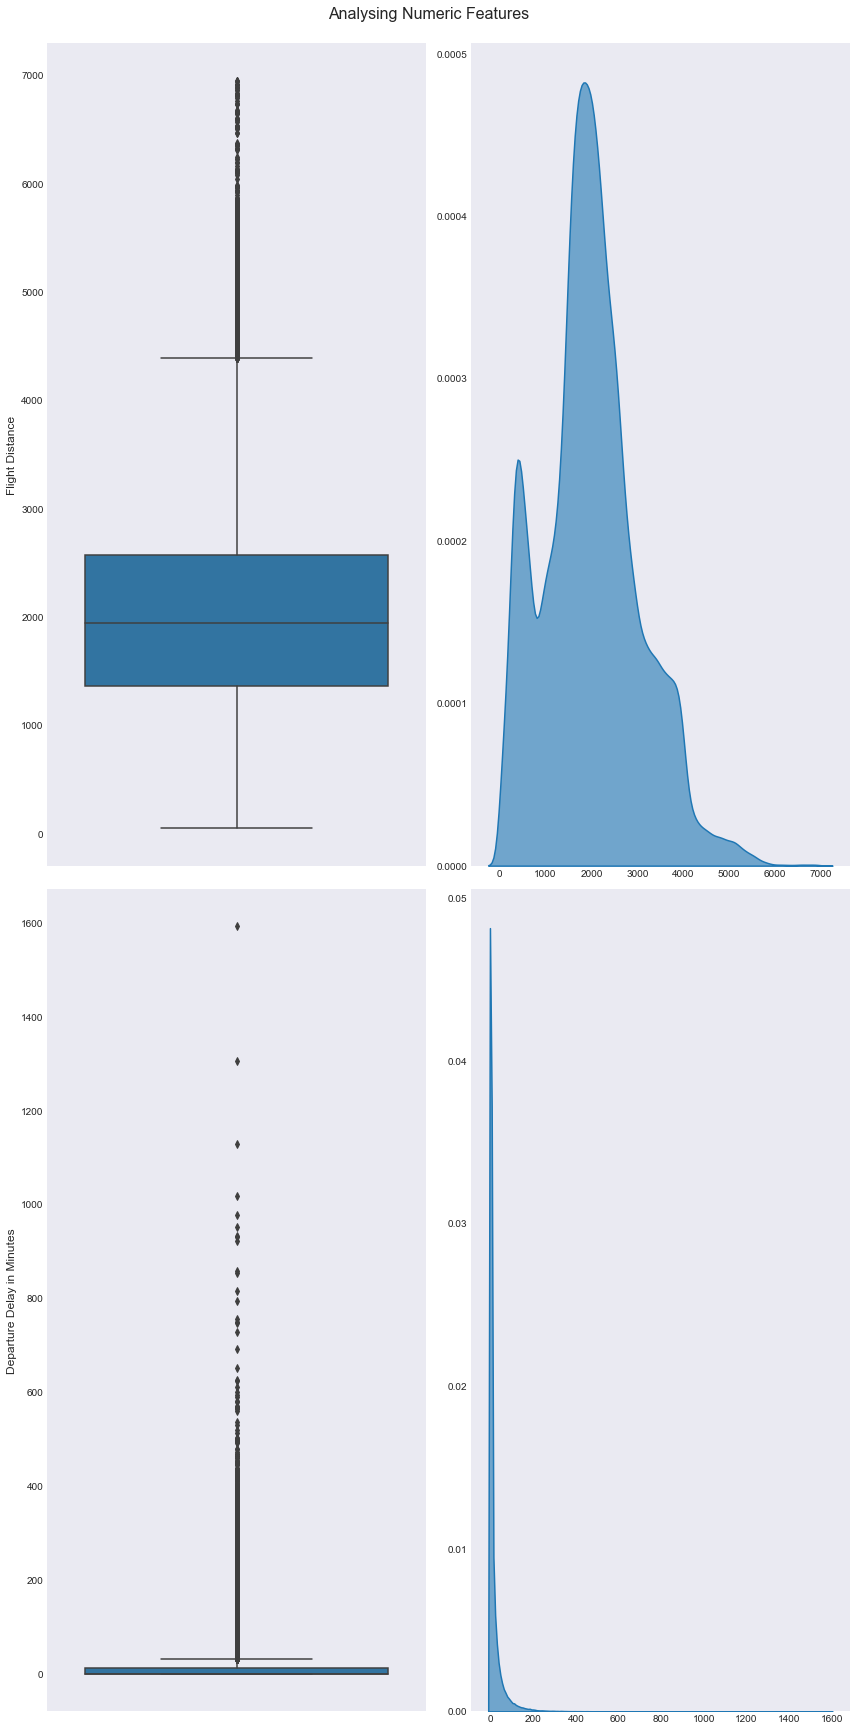

In [34]:
# plot boxplots and kernel density estimation (KDE)
fig, ax3 = plt.subplots(2, 2, figsize = (12, 24))
for i, num_var in enumerate(df_numeric):
    sns.boxplot(y = num_var, data = df_numeric, ax = ax3[i][0])

    sns.kdeplot(x = num_var, data = df_numeric, ax = ax3[i][1],
               fill = True, alpha = 0.6, linewidth = 1.5)
    
    ax3[i][0].set_ylabel(f"{num_var}", fontsize = 12)
    ax3[i][0].set_xlabel(None)
    ax3[i][1].set_xlabel(None)
    ax3[i][1].set_ylabel(None)

fig.suptitle('Analysing Numeric Features', fontsize = 16, y = 1)
plt.tight_layout()

In [35]:
# create and function to detect extreme outliers (3 x IQR more extreme than the first and third quartiles.)
def outer_fences_outlier_values(data):
    cc = 0     # column counter
    olc = 0    # columns with outer fences outlier values counter 
    for i in data.columns: 
        IQR = np.quantile(data[i], 0.75) - np.quantile(data[i], 0.25)       
        outlier = np.logical_or(data[i] < (np.quantile(data[i], 0.25) - (IQR * 3)), data[i] > np.quantile(data[i], 0.75) + (IQR * 3))
        num_outlier = outlier.sum()
        pct_outlier = outlier.mean()*100 
        cc = cc + 1
    
        if num_outlier > 0:
            print(f'Column with outlier-value: {i:26} {num_outlier:8} outliers {pct_outlier:8.3f}% of the values is outliers')
            olc = olc + 1
        
        if cc == len(data.columns) and olc == 0:
            print(f'No outlier values (checked {cc} columns out of {len(data.columns)} columns)')

In [36]:
outer_fences_outlier_values(df_numeric)

Column with outlier-value: Flight Distance                  49 outliers    0.041% of the values is outliers
Column with outlier-value: Departure Delay in Minutes    10261 outliers    8.604% of the values is outliers


In [37]:
# check the mean, std and percentile of the numerical features
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
Flight Distance,119255.0,1994.709144,1038.057310,50.0,1359.0,1941.0,2571.0,6951.0
Departure Delay in Minutes,119255.0,14.824552,38.158017,0.0,0.0,0.0,12.5,1592.0


In [38]:
# keep all instances from the df with an ‘Flight Distance value higher than or equal to 200
df = df[df['Flight Distance'] >= 200]
# keep all instances from the df with an ‘Departure Delay in Minutes’ lower than or equal to 720 
df = df[df['Departure Delay in Minutes'] <= 720]

### 1.4.1 Unique values categorical features

Avoiding unique values with a low value count is preferable when you are conducting tree-based learning as I do when I use the XGBoost classifier. Otherwise the trees have to work harder to split the data. This is simply because the more unique values in the feature, the more splits the tree has to make to separate the data. 
This effect is most apparent with the max depth hyperparameters that I’m going to tune later on since it controls how far the data can be split. Any increase in the max depth value will in turn increase model training time. I want my model to be fast both through feature selection and hyperparameter tuning. Hence I check the minimum value count for every categorical feature i.e. how many times is the least popular unique value in each feature set 

In this case a unique values with a low value count is not a problem as can be seen below

In [39]:
# number of times the least popular value in each categorical feature appear 
for i in df_categorical:
    print(f'{i:33} {df[i].value_counts().min():6}')

Gender                             58353
Customer Type                      19178
Type of Travel                     36326
Class                               8639
Baggage handling                    6680
Inflight wifi service              13048
Online support                     12196
Ease of Online booking             11617
Gate location                      17868
Food and drink                     19204
Online boarding                    13622
On-board service                   11843
Leg room service                    9752
Checkin service                    14000
Cleanliness                         6568
Satisfaction                       54227
Age Group                           1562


## 1.5. Encoding and create train and test sets

In [40]:
# convert the values in the target variable to binary
df.Satisfaction = df.Satisfaction.map({'satisfied':1, 'neutral or dissatisfied':0})
df = df.reset_index(drop=True)

In [41]:
# one-hot encode the categorical features
categorical_to_encode = df.select_dtypes(include='object')
categorical_encoded = pd.get_dummies(categorical_to_encode)

In [42]:
# scale the numerical features through standardization to ease the GLM classifier's regularization 
scalar = StandardScaler()
to_scale = df.select_dtypes(include='int64') 
to_scale = to_scale.drop(['Satisfaction'],axis=1)
numeric_scaled = pd.DataFrame(scalar.fit_transform(to_scale), columns = to_scale.columns)

In [43]:
# create the predict and target variables
X = pd.concat([numeric_scaled, categorical_encoded], axis = 1)
y = df.Satisfaction

In [44]:
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True)

# 2. GLM - Logistic regression

In [45]:
"""
A function that creates a classifier through Scikit-learn's Logistic Regression CV.
Check the ROC and AUC of that classifier, 
and return the rounded AUC score and the classifier.
"""
def glm_model(Xtrain, ytrain, Xtest, ytest):
    glm_clf = LogisticRegressionCV(cv=5, penalty='l1', scoring='neg_log_loss', solver = 'liblinear', verbose=0, n_jobs=-1, random_state=RANDOM_STATE, max_iter=10000).fit(Xtrain, ytrain)
    # ROC and AUC
    glm_fpr, glm_tpr, glm_threshold = metrics.roc_curve(ytest, glm_clf.predict_proba(Xtest)[:,1]) 
    glm_auc = metrics.auc(glm_fpr, glm_tpr)
    
    return np.round(glm_auc,5), glm_clf

In [46]:
# create the first glm_model
glm_model_1 = glm_model(Xtrain = X_train, ytrain = y_train, Xtest = X_test, ytest = y_test)
# the AUC and the classifier from the first model
glm_auc_1 = glm_model_1[0]
glm_clf_1 = glm_model_1[1] 

In [47]:
print(f'AUC: {glm_auc_1}')

AUC: 0.92609


## 2.1 Recursive Feature Elimination (RFE)
I have run the Recursive Feature Elimination (RFE) with cross-validation and assigned the features to keep to rfecv_features. I put the code for the RFE between quotation marks after that to speed up the run of the notebook. If you still want to run the RFE, remove the brackets and replace the rfecv_features with rfecv.support_ in the "X_train.loc[], X_test.loc[]" cell. 

In [48]:
"""rfecv = RFECV(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', verbose=True, random_state=RANDOM_STATE, max_iter=10000),
    n_jobs=-1,
    cv=5,
    step=1,
    min_features_to_select=10,
    scoring='neg_log_loss',
    verbose=True,
)

rfecv = rfecv.fit(X_train, y_train)

print(rfecv.support_)
print(rfecv.ranking_)
X_train.columns[rfecv.support_]"""

"rfecv = RFECV(\n    estimator=LogisticRegression(penalty='l1', solver='liblinear', verbose=True, random_state=RANDOM_STATE, max_iter=10000),\n    n_jobs=-1,\n    cv=5,\n    step=1,\n    min_features_to_select=10,\n    scoring='neg_log_loss',\n    verbose=True,\n)\n\nrfecv = rfecv.fit(X_train, y_train)\n\nprint(rfecv.support_)\nprint(rfecv.ranking_)\nX_train.columns[rfecv.support_]"

In [49]:
# the features to keep after feature selection with RFE (60 features) 
rfecv_features = ['Flight Distance', 'Departure Delay in Minutes', 'Gender_Female',
       'Gender_Male', 'Customer Type_Loyal Customer',
       'Customer Type_disloyal Customer', 'Type of Travel_Business travel',
       'Type of Travel_Personal Travel', 'Class_Business', 'Class_Eco',
       'Baggage handling_1', 'Baggage handling_3', 'Baggage handling_5',
       'Inflight wifi service_1.0', 'Inflight wifi service_2.0',
       'Inflight wifi service_4.0', 'Inflight wifi service_5.0',
       'Online support_1.0', 'Online support_2.0', 'Online support_3.0',
       'Online support_5.0', 'Ease of Online booking_1.0',
       'Ease of Online booking_2.0', 'Ease of Online booking_4.0',
       'Ease of Online booking_5.0', 'Gate location_1.0', 'Gate location_2.0',
       'Gate location_4.0', 'Gate location_5.0', 'Food and drink_1.0',
       'Food and drink_2.0', 'Food and drink_3.0', 'Food and drink_4.0',
       'Food and drink_5.0', 'Online boarding_1.0', 'Online boarding_2.0',
       'Online boarding_3.0', 'Online boarding_5.0', 'On-board service_1.0',
       'On-board service_2.0', 'On-board service_4.0', 'On-board service_5.0',
       'Leg room service_1.0', 'Leg room service_2.0', 'Leg room service_3.0',
       'Leg room service_4.0', 'Leg room service_5.0', 'Checkin service_1.0',
       'Checkin service_2.0', 'Checkin service_5.0', 'Cleanliness_1.0',
       'Cleanliness_3.0', 'Cleanliness_4.0', 'Cleanliness_5.0',
       'Age Group_20s', 'Age Group_30s', 'Age Group_40s', 'Age Group_60s',
       'Age Group_Kid', 'Age Group_Senior']

In [50]:
# keep only the features from rfecv (60 features)
X_train = X_train.loc[:, rfecv_features]
X_test = X_test.loc[:,rfecv_features]

### Comment - Logistic Regression classifiers
Having completed the feature selection, the same steps as for the first model glm_model_1 is now done on a new model glm_model_final. I also compare the two models AUC against each other.

In [51]:
# create the final glm_model
glm_model_final = glm_model(Xtrain = X_train, ytrain = y_train, Xtest = X_test, ytest = y_test)
# the AUC and the classifier from the final model
glm_auc_final = glm_model_final[0]
glm_clf_final = glm_model_final[1] 

In [52]:
print(f'AUC: {glm_auc_final}')

AUC: 0.92607


### 2.1.1 Compare AUC, Logistic regression 

The contribution from the other features that was removed by the RFE made little difference to the projects main evaluation metric AUC since it’s still on a high 0.92 value, but the classifier converges faster when the model glm_model_final only use 60 features instead of 74 features. 

In [53]:
print(f'AUC final: {glm_auc_final}')
print(f'AUC 1:     {glm_auc_1}')

AUC final: 0.92607
AUC 1:     0.92609


### Comment - Cut off thresholds 
Since AUC evaluates the classifier over all possible thresholds (while a fixed threshold is used when evaluating with the confusion matrix) I construct a function “prediction_certainty” with two graphs, one for each binary value in the target variable. The graphs are particularly helpful for two reasons:
1. They show the relationship between the different prediction cut off values and the corresponding True Positive, False Positive, True Negative and False Negative-rates. In connection with the AUC score I can easier interpret what cut off value to choose for 1 and still keep a high True Positive Rate by e.g. I want a minimum True Positive Rate of 0.9 the cut off value of 1 is then 0.4 which means the cut off value for 0 is 0.6 (1-0.4) and the corresponding False Positive Rate is 0.22. This is a more interpretable way than looking at the ROC curve which displays the same True Positive and False Positive rates.


2. I get the prediction certainty for different prediction cut off values in connection with True Positive Rate and True Negative Rate, hence I can choose the cut-off values for 1 and 0 that maximize the classifier to correctly classify 1 as 1’s and 0 as 0’s.

Keep in mind though that the choice of which ratio to tolerate for the four different rates is purely a business decision. What rate that is most important to maximize or minimize varies between organizations and situations.


In [54]:
def prediction_certainty(y_true, y_proba):
    actual_0 = len(y_true[y_true == 0])
    actual_1 = len(y_true[y_true == 1])

    interval = np.linspace(0,1,11)
    interval_list_0 = np.repeat(0.0, 11)
    interval_list_1 = np.repeat(0.0, 11)

    for i in range(len(interval_list_0)):
        interval_list_0[i] = round(np.logical_and(y_true == 0, y_proba[:,0] <= interval[i]).sum() / actual_0, 4)
    for i in range(len(interval_list_1)):
        interval_list_1[i] = round(np.logical_and(y_true == 1, y_proba[:,1] <= interval[i]).sum() / actual_1, 4)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5)
    fig.suptitle('Prediction Certainty', fontsize=16)
    ax1.plot(interval,interval_list_0, 'm.-'), ax2.plot(interval,interval_list_1, 'c.-')

    number_ticks = np.arange(0, 1.0001, step=0.1)
    clean_ticks = np.arange(0, 1.0001, step=0.05)

    ax1.set(xlim = [0, 1], xticks=number_ticks, yticks=number_ticks,
    xlabel = "Maximum cut off value for setting prediction to 0", ylabel = 'False Positive Rate')
    ax2.set(xlim = [0, 1], xticks=number_ticks, yticks=number_ticks,
    xlabel = "Maximum cut off value for setting prediction to 1", ylabel = 'False Negative Rate')
    
    ax1.set_ylim(bottom=0, top=1), ax2.set_ylim(bottom=0, top=1)
    ax1.set_xticks(clean_ticks, minor=True), ax1.set_yticks(clean_ticks, minor=True)
    ax2.set_xticks(clean_ticks, minor=True), ax2.set_yticks(clean_ticks, minor=True)
    ax1.grid(which='minor', alpha=0.2), ax1.grid(which='major', alpha=0.5)
    ax2.grid(which='minor', alpha=0.2), ax2.grid(which='major', alpha=0.5)

    ax1_1 = ax1.twinx()
    ax2_1 = ax2.twinx()
    ax1_1.set_yticks(clean_ticks, minor=True),ax2_1.set_yticks(clean_ticks, minor=True)
    ax1_1.set_ylim(bottom=1, top=0),ax2_1.set_ylim(bottom=1, top=0)
    ax1_1.set(yticks=(np.arange(1.0, -0.1,-0.1)), ylabel = 'True Negative Rate')
    ax2_1.set(yticks=(np.arange(1.0, -0.1,-0.1)), ylabel = 'True Positive Rate')

    return plt.show()

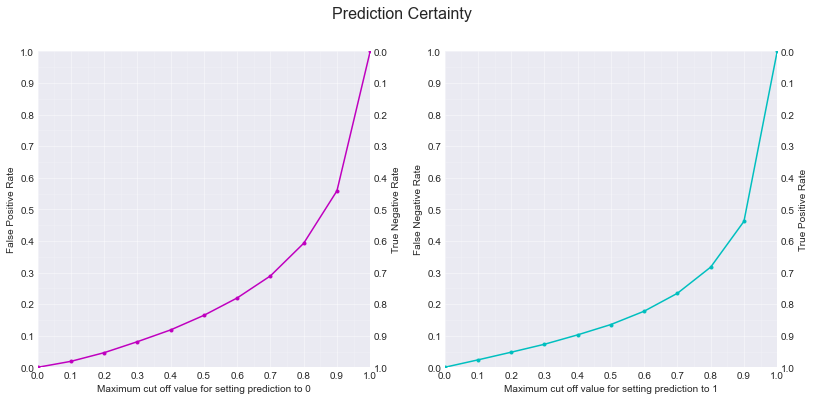

In [55]:
glm_prediction_certainty = prediction_certainty(y_test, glm_clf_final.predict_proba(X_test))
glm_prediction_certainty

# 3. XGBoost

It’s time for the other model Extreme Gradient Boosting (XGBoost), XGBoost is a decision-tree-based ensemble model. 

I have done a detailed description of both XGBoost and its hyperparameter tuning with Bayesian optimization in my other project ‘churn-hotel-xgboost-alibi’ so I don’t focus on describing these two subjects as much in this project. I have instead made sure to thoroughly comment in the cells regarding XGBoost and Bayesian optimization. 

If you still want to read what I have wrote about the XGBoost ensemble model and hyperparameter tuning with Bayesian optimization here’s the link to my other project: https://github.com/lennartwallentin/churn-hotel-xgboost-alibi/blob/main/churn_xgboost_alibi_lennart_wallentin.ipynb     

In [56]:
# restore train and test sets for XGBoost modeling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y, shuffle=True)

In [57]:
# set XGBoost parameters
params = {
    'booster' : 'gbtree', 
    'objective' : 'binary:logistic', 
    'eval_metric': 'logloss', 
    'seed': RANDOM_STATE 
    }

In [58]:
"""
A function that creates a XGBoost classifier after first done cross-validation with log loss as evaluation metric 
and early-stopping rounds set to 10. Log loss is also set as the classifier's evaluation metric. 
The function also checks the ROC and AUC of the classifier, and returns the rounded AUC score and the classifier.    
"""
def xgb_model(params, Xtrain, ytrain, Xtest, ytest):
    # cast the train partition to dmatrix
    dmatrix = xgb.DMatrix(Xtrain, ytrain)
    # preform a cross-validation to approximate the preferable n_estimator (optimal number of boosting rounds) for the XGBoost classifier
    xgb_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=5, num_boost_round=500, early_stopping_rounds=10, verbose_eval=0, seed=RANDOM_STATE, shuffle=False)
    # get the the best iteration (lowest test log loss) from xgb_cv, it will be used as the number of boosting rounds in the classifier
    iter_best = len(xgb_cv)
    # create a XGBClassifer instance and train the model. 
    xgb_clf = xgb.XGBClassifier(n_estimators=iter_best, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss').fit(Xtrain, ytrain)
    # ROC and AUC
    xgb_fpr, xgb_tpr, xgb_threshold = metrics.roc_curve(ytest, xgb_clf.predict_proba(Xtest)[:,1]) 
    xgb_auc = metrics.auc(xgb_fpr, xgb_tpr)

    return np.round(xgb_auc,5), xgb_clf

In [59]:
# create the first xgb_model
xgb_model_1 = xgb_model(params = params, Xtrain = X_train, ytrain = y_train, Xtest = X_test, ytest = y_test)
# the AUC and the classifier from the xgb_model_1
xgb_auc_1 = xgb_model_1[0]
xgb_clf_1 = xgb_model_1[1]

In [60]:
print(f'AUC: {xgb_auc_1}')

AUC: 0.98342


### 3.0.1 Feature importance plot

Plot the feature importance plot. The plot is constructed by how many times a feature is used in the trees, weighted by how many observations it splits in each node. 
This ensures that a feature closer to the root gets a higher gain-score than a feature further from the root.

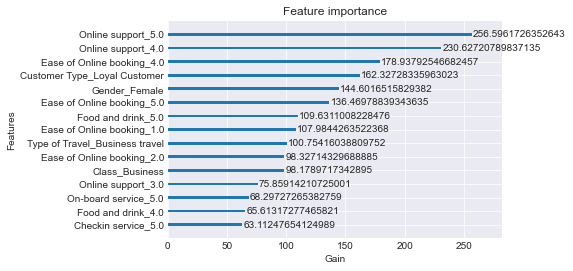

In [61]:
# importance plot showing the 15 feature with the highest gain score 
xgb.plot_importance(xgb_clf_1, max_num_features=15, importance_type = 'gain', xlabel='Gain')
plt.show()

### Comment - 'Online support'

Both “Online support_5.0” and “Online support_4.0” gets a high gain score, I investigate these features further with the preprocessed dataset df, but can’t find anything suspicious other than many people have given the Online support a high rating.

In a real project I would of course talk to stakeholders to get an even more in depth view about the "Online support" feature.

In [62]:
print(df.groupby("Online support")["Satisfaction"].value_counts().loc[5.0],'\n')
print(df.groupby("Online support")["Satisfaction"].value_counts().loc[4.0],'\n')

Satisfaction
1    25211
0     7273
Name: Satisfaction, dtype: int64 

Satisfaction
1    25905
0    12222
Name: Satisfaction, dtype: int64 



In [63]:
print(df.groupby("Online support")["Satisfaction"].value_counts())


Online support  Satisfaction
1.0             0                9056
                1                3140
2.0             0               11301
                1                4040
3.0             0               14375
                1                5030
4.0             1               25905
                0               12222
5.0             1               25211
                0                7273
Name: Satisfaction, dtype: int64


### 3.0.2 Gain score and feature selection

I checked the gain score for xgb_model_1 and tried different gain score cut off values for the classifier but ended up keeping the 30 features with the highest gain score (cut almost 60% of the df’s features) for the xgb_model_2. One other method to do the feature selection is to use the functions from my other project: “feature_selection_functions” https://github.com/lennartwallentin/feature_selection_functions   

In [64]:
# Array with the 30 highest gain scores (feature names not displayed)
np.array(sorted(xgb_clf_1.get_booster().get_score(importance_type='gain').values(),reverse=True)[:30])

array([256.59617264, 230.6272079 , 178.93792547, 162.32728336,
       144.60165158, 136.46978839, 109.63110082, 107.98442635,
       100.75416039,  98.3271433 ,  98.17897173,  75.85914211,
        68.29727265,  65.61317277,  63.11247654,  57.65109063,
        46.36088727,  45.94415079,  44.43288579,  40.75658664,
        35.99972624,  34.83081035,  31.94106393,  29.75692305,
        27.67741108,  25.37583952,  24.2768383 ,  19.85072496,
        19.42845261,  16.87915814])

In [65]:
# the feature names of the features I keep, and their corresponding gain score
sorted(xgb_clf_1.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1], reverse=True)[:30]

[('Online support_5.0', 256.5961726352643),
 ('Online support_4.0', 230.62720789837135),
 ('Ease of Online booking_4.0', 178.93792546682457),
 ('Customer Type_Loyal Customer', 162.32728335963023),
 ('Gender_Female', 144.6016515829382),
 ('Ease of Online booking_5.0', 136.46978839343635),
 ('Food and drink_5.0', 109.6311008228476),
 ('Ease of Online booking_1.0', 107.9844263522368),
 ('Type of Travel_Business travel', 100.75416038809752),
 ('Ease of Online booking_2.0', 98.32714329688885),
 ('Class_Business', 98.1789717342895),
 ('Online support_3.0', 75.85914210725001),
 ('On-board service_5.0', 68.29727265382759),
 ('Food and drink_4.0', 65.61317277465821),
 ('Checkin service_5.0', 63.11247654124989),
 ('Online boarding_5.0', 57.6510906277778),
 ('Baggage handling_5', 46.3608872699191),
 ('Leg room service_4.0', 45.94415078978288),
 ('Leg room service_5.0', 44.43288578518919),
 ('Baggage handling_3', 40.756586636020835),
 ('Online boarding_2.0', 35.99972624055675),
 ('Cleanliness_5.0'

In [66]:
# get the gain scores from xgb_clf_1, sort in descending order, and keep 40.5 % of the features   
gain_score = xgb_clf_1.get_booster().get_score(importance_type='gain')
gain_score_df = pd.DataFrame.from_dict(gain_score, orient='index', columns = ['gain']).gain.sort_values(ascending=False)
features_keep = gain_score_df.iloc[:30]

In [67]:
# keep only the features with the top 40.5 % highest gain scores 
X_train = X_train.loc[:,X_train.columns.isin(features_keep.index)]
X_test = X_test.loc[:,X_test.columns.isin(features_keep.index)]

### Comment - XGBoost classifiers
Having completed the feature selection, the same steps as for the first model xgb_model_1 is now done on a new classifier xgb_model_2. I also compare the two models AUC score.

In [68]:
# create the second xgb_model
xgb_model_2 = xgb_model(params = params, Xtrain = X_train, ytrain = y_train, Xtest = X_test, ytest = y_test)
# the AUC and the classifier from the xgb_model_2
xgb_auc_2 = xgb_model_2[0]
xgb_clf_2 = xgb_model_2[1]

In [69]:
print(f'AUC: {xgb_auc_2}')

AUC: 0.98147


### 3.0.3 Compare AUC, XGBoost

The contribution from the other features with low gain score made little difference to the projects main evaluation metric AUC since it’s still on 0.98 but the model is faster when the model xgb_model_2 only use 40.5 % of the original features  

In [70]:
print(f'AUC xgb_model_2: {xgb_auc_2}')
print(f'AUC xgb_model_1: {xgb_auc_1}')

AUC xgb_model_2: 0.98147
AUC xgb_model_1: 0.98342


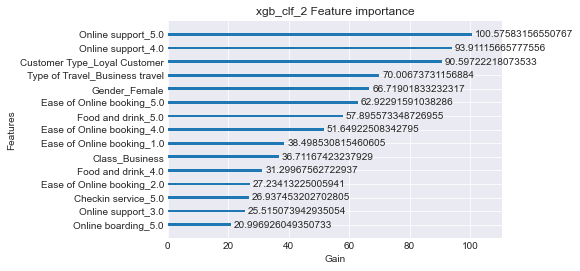

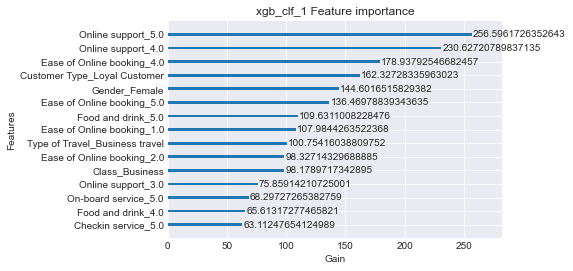

In [71]:
# importance plot showing the 15 features with the highest gain score 
xgb.plot_importance(xgb_clf_2, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_clf_2 Feature importance')
plt.show()
xgb.plot_importance(xgb_clf_1, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_clf_1 Feature importance')
plt.show()

## 3.1 XGBoost hyperparameter tuning with Bayesian optimization 

I have run the Bayesian optimization and assigned the optimised values to params_tuned. I put the code between quotation marks after that, because the Bayesian optimizer takes about 1 hour and 10 minutes to run on a computer with:

* Processor: Intel® Core™ i5 10600k 4,8GHZ 
* Graphic card: Nvidia Geforce RTX2060 6GB (OC-version)
* RAM: 16GB DDR4 2666MHz 

I have created a copy of params_tuned so the rest of the project will still run smoothly and saved the output from the Bayesian optimizer in a separate xlsx file ‘bayesian_optimization_iterations.xlsx’ that you can download from my repository. 

If you want to test the Bayesian optimization anyway, remove the quotation marks and delete the cell containing the copy of params_tuned. 

In [72]:
def XGbcv(eta, lambda_bo, alpha, max_depth, gamma, min_child_weight, colsample_bytree):
    LOGLOSSbest = 1.
    ITERbest = 0

    paramt = {
              'booster' : 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'seed' : RANDOM_STATE,
              'eta' : eta, # learning rate
              'lambda' : lambda_bo, # L2 regularization term 
              'alpha' : alpha, # L1 regularization term
              'max_depth' : max_depth.astype(int), # max depth of the trees
              'gamma' : gamma, # pruning of the trees
              'min_child_weight' : min_child_weight, # min number of observations in each leaf
              'colsample_bytree' : colsample_bytree # ratio of variables to choose from in each split
              }

    xgbc = xgb.cv(
           params = paramt,
           dtrain = dtrain,
           num_boost_round = xgb_clf_2.n_estimators,
           nfold = 5,
           verbose_eval = False,
           early_stopping_rounds = 10,
           seed=RANDOM_STATE,
           shuffle=False
          )

    cv_score = xgbc['test-logloss-mean'].iloc[-1]
    if ( cv_score < LOGLOSSbest ):
        LOGLOSSbest = cv_score
        ITERbest = len(xgbc)

    return (-1.0 * cv_score)

In [73]:
"""dtrain = xgb.DMatrix(X_train, y_train)

print("# Global Optimization Search for XGBoost Parameters")
print("\n Please note that negative Log Loss values will be shown below. This is because")
print(" Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.\n")

XGbBO = BayesianOptimization(XGbcv, {'max_depth': (8, 12),
                                     'gamma': (0.2, 0.8),
                                     'min_child_weight': (1, 6),
                                     'colsample_bytree' :(0.6, 1),
                                     'eta' :(0.01, 0.25),
                                     'lambda_bo': (0, 1),
                                     'alpha': (0.7, 1)}, 
                                     random_state = RANDOM_STATE)

XGbBO.maximize(init_points=25, n_iter=575, acq="ucb", kappa = 2.85, kappa_decay = 0.999, kappa_decay_delay = 50)
print("-" * 53)

best_LOGLOSS = round((-1.0 * XGbBO.max['target']), 6)
alpha = round(XGbBO.max['params']['alpha'], 6)
colsample_bytree = round(XGbBO.max['params']['colsample_bytree'], 6)
eta = round(XGbBO.max['params']['eta'], 6)
gamma = round(XGbBO.max['params']['gamma'], 6)
lambda_bo = round(XGbBO.max['params']['lambda_bo'], 6)
max_depth = round(XGbBO.max['params']['max_depth'])
min_child_weight = round(XGbBO.max['params']['min_child_weight'], 6)

print("\n Best Log Loss value: %f" % best_LOGLOSS)
print(" Best XGBoost parameters:")
print(" max_depth=%d, gamma=%f, min_child_weight=%f, colsample_bytree=%f, eta=%f, lambda_bo=%f, alpha=%f" % (int(max_depth), gamma, min_child_weight, colsample_bytree, eta, lambda_bo, alpha))"""

'dtrain = xgb.DMatrix(X_train, y_train)\n\nprint("# Global Optimization Search for XGBoost Parameters")\nprint("\n Please note that negative Log Loss values will be shown below. This is because")\nprint(" Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.\n")\n\nXGbBO = BayesianOptimization(XGbcv, {\'max_depth\': (8, 12),\n                                     \'gamma\': (0.2, 0.8),\n                                     \'min_child_weight\': (1, 6),\n                                     \'colsample_bytree\' :(0.6, 1),\n                                     \'eta\' :(0.01, 0.25),\n                                     \'lambda_bo\': (0, 1),\n                                     \'alpha\': (0.7, 1)}, \n                                     random_state = RANDOM_STATE)\n\nXGbBO.maximize(init_points=25, n_iter=575, acq="ucb", kappa = 2.85, kappa_decay = 0.999, kappa_decay_delay = 50)\nprint("-" * 53)\n\nbest_LOGLOSS = round((-1.0 * XGbBO.max[\'target\']

In [74]:
# from the iteration with 'Best Log Loss value' set parameters to their optimal estimated values 
"""params_tuned = {
    'booster' : 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed' : RANDOM_STATE,
    'learning_rate' : eta,
    'reg_lambda' : lambda_bo,
    'reg_alpha' : alpha,
    'max_depth' : max_depth,
    'gamma' : gamma,
    'min_child_weight' : min_child_weight,
    'colsample_bytree' : colsample_bytree
    }

params_tuned"""

"params_tuned = {\n    'booster' : 'gbtree',\n    'objective': 'binary:logistic',\n    'eval_metric': 'logloss',\n    'seed' : RANDOM_STATE,\n    'learning_rate' : eta,\n    'reg_lambda' : lambda_bo,\n    'reg_alpha' : alpha,\n    'max_depth' : max_depth,\n    'gamma' : gamma,\n    'min_child_weight' : min_child_weight,\n    'colsample_bytree' : colsample_bytree\n    }\n\nparams_tuned"

In [75]:
# copy of params_tuned, use it when Bayesian optimization isn't used
params_tuned = {'booster': 'gbtree',
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': RANDOM_STATE,
 'learning_rate': 0.109522,
 'reg_lambda': 0.425498,
 'reg_alpha': 0.976374,
 'max_depth': 11,
 'gamma': 0.714145,
 'min_child_weight': 2.654017,
 'colsample_bytree': 0.736561}

In [76]:
"""
This function is similar to the xgb_model function with the exemption that the optimized hyperparameter values 
are added to the classifier instance. 
The function returns the classifiers rounded AUC score and the classifier. 
"""
def xgb_tuned_model(params, Xtrain, ytrain, Xtest, ytest):
    # cast the train partition to dmatrix
    dmatrix = xgb.DMatrix(Xtrain, ytrain)
    # preform a cross-validation to approximate the preferable n_estimator (optimal number of boosting rounds) for the XGBoost classifier
    xgb_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=5, num_boost_round=500, early_stopping_rounds=10, verbose_eval=0, seed=RANDOM_STATE, shuffle=False)
    # get the the best iteration (lowest test log loss) from xgb_cv_1, it will be used as the number of boosting rounds in the classifier
    iter_best = len(xgb_cv)
    # create a XGBClassifer instance and train the model. 
    xgb_clf = xgb.XGBClassifier(n_estimators=iter_best, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss',
    learning_rate=0.109522, reg_lambda=0.425498, reg_alpha=0.976374, max_depth=11, gamma=0.714145, min_child_weight=2.654017, colsample_bytree = 0.736561).fit(Xtrain, ytrain)
    # ROC and AUC
    xgb_fpr, xgb_tpr, xgb_threshold = metrics.roc_curve(ytest, xgb_clf.predict_proba(Xtest)[:,1]) 
    xgb_auc = metrics.auc(xgb_fpr, xgb_tpr)

    return np.round(xgb_auc,5), xgb_clf

In [77]:
# create the final XGBoost model
xgb_model_final = xgb_tuned_model(params = params_tuned, Xtrain = X_train, ytrain = y_train, Xtest = X_test, ytest = y_test)
# the AUC and the classifier from the xgb_model_final
xgb_auc_final = xgb_model_final[0]
xgb_clf_final = xgb_model_final[1]

In [78]:
print(f'AUC: {xgb_auc_final}')

AUC: 0.98187


### 3.1.1 Compare AUC, XGBoost hyperparameter tuned

There is a minimal difference regarding the AUC for the hyperparameter tuned model xgb_model_final and non-tuned xgb_model_2. 

But the hyperparameter tuned classifier have a higher AUC score and the two model have the same number of features so I choose to use xgb_model_final classifier's AUC score as benchmark to compare against the Stacked model

In [79]:
# compare the the tuned and non-tuned classifiers AUC 
print(f'AUC xgb_model_final: {xgb_auc_final}')
print(f'AUC xgb_model_2:     {xgb_auc_2}')

AUC xgb_model_final: 0.98187
AUC xgb_model_2:     0.98147


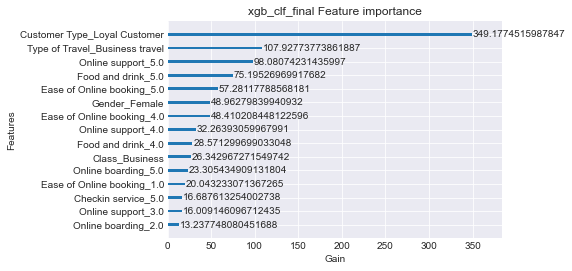

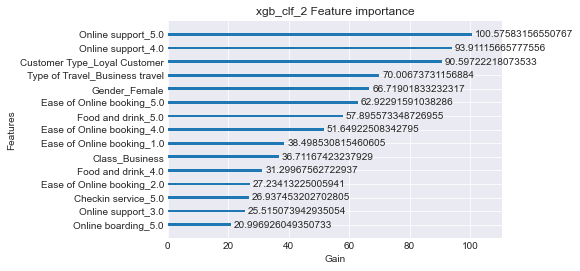

In [80]:
# importance plot showing the 15 features with the highest gain score 
xgb.plot_importance(xgb_clf_final, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_clf_final Feature importance')
plt.show()
xgb.plot_importance(xgb_clf_2, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_clf_2 Feature importance')
plt.show()

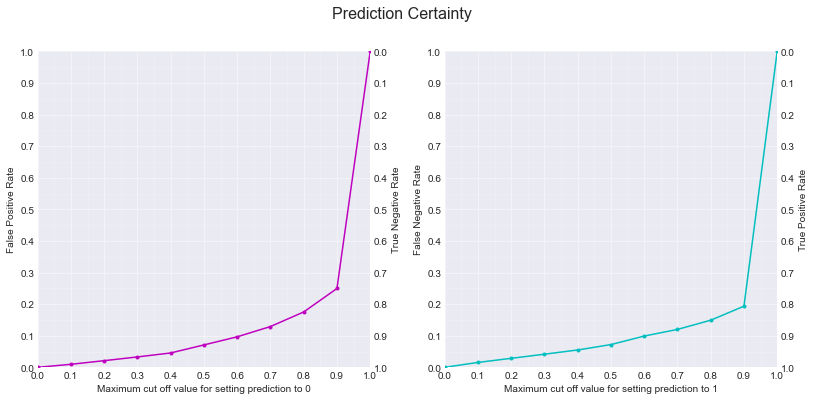

In [81]:
xgb_prediction_certainty = prediction_certainty(y_test, xgb_clf_final.predict_proba(X_test))
xgb_prediction_certainty

# 4. Stacking
Note: A more detailed description regarding the neural network I'm building is conducted in section 4.3 Stacking Meta Learner - Neural network (Keras and TensorFlow)

Stacked Generalization (Stacking) is the process of using different machine learning models also called base learners one after another, whereupon you add the predictions from each base learner to make a new feature that is then used by a final generalized machine learning model also called meta learner. It is important that the base learners produce different predictions, so-called uncorrelated predictions because stacking works best when the predictions that are combined are all good, but good in different ways. That’s why I’ve chosen to use Logistic Regression and XGBoost as my base learners because they are two different machine learning models (e.g. XGBoost have high variance and low bias while Logistic regression have low variance and high bias). 
<br>A neural network built with Keras and TensorFlow is used as a meta learner to compare if the AUC for the stacked model is better than the AUC of two standalone XGBoost and GLM - Logistic regression models I constructed earlier in the notebook, and also the better than the AUC score of my stacked generalization meta learner built with XGBoost from my previous project .</br>   

Note: that there is no correct way of implementing stacking other than it’s a process of combining many models/base learners with a final generalized model/meta learner. Hence I make sure that the base and meta learners are accompanied by model validation to reduce overfitting models to the training data. I also use feature selection and tune the hyperparameters of the base learners and the meta learner to further lift performance and speed of the models. With that in mind, my aim is to get the best possible AUC score and compare that with the standalone Logistic regression and XGBoost models and previous XGBoost meta learner AUC score.   

The steps for doing the stacking is roughly as follows:
1. Recreate the preprocessed dataframe df and use that to create two new dataframes, one for the meta learner (df_meta) and one for the base learner (df_base). 
2. Use df_base, create a train and test set for the base learner. Then create the base learner GLM - Logistic regression with cross-validation and I also do feature selection with Recursive Feature Elimination (RFE)
3. Because I’ve done feature selection on the Logistic regression base learner I need to restore the train and test set for the base learner before I can create the second base learner that will be the XGBoost algorithm 
4. Create the XGBoost base learner and perform cross-validation then feature selection by comparing the features gain score, finally do hyperparameter tuning with Bayesian optimization, then the XGBoost base learner is completed.
5. Use the best GLM - Logistic regression and XGBoost base learner models to get probabilities from the df_meta dataframe. Then assign those probabilities to df_meta, one column for the GLM base learner and one column for the XGBoost base learner. By doing this the meta learner is “stacked” with two extra features, df_meta probabilities from each one of the base learners. 
6. Use the newly stacked df_meta to create a train and test set for the neural network meta learner. 
7. Perform model validation and hyperparameter tuning on the meta learner. 
8. Get the AUC score for the meta learner and compare that score with the AUC score for the standalone GLM - Logistic regression and the XGBoost models and the XGBoost meta learner from my previous project.

In [82]:
# AUC benchmark from individual models
print(f'AUC GLM:     {glm_auc_final}')
print(f'AUC XGBoost: {xgb_auc_final}')

AUC GLM:     0.92607
AUC XGBoost: 0.98187


In [83]:
# create the df used for the stacking
df_stacking = pd.concat([numeric_scaled, categorical_encoded, df.Satisfaction], axis = 1)

In [84]:
# Creating df_meta for the meta learner with 70% of the values from the original dataframe 
# frac chose values randomly i.e. data is shuffled but random_state keeps it consistent for every notebook run
df_meta = df_stacking.sample(frac=0.70, random_state=RANDOM_STATE)

# Creating df_base for the base learners with the 30% remaining values from original dataframe 
df_base = df_stacking.drop(df_meta.index)

In [85]:
# create the predict and target variables for the base learners
y_base = df_base.Satisfaction
X_base = df_base.drop('Satisfaction', axis=1)

# create train and test set for the base learners
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=RANDOM_STATE, stratify=y_base, shuffle=True)

## 4.1 Stacking Base Learner - GLM - Logistic Regression

In [86]:
# create the first GLM base model
glm_base_1 = glm_model(Xtrain = X_train_base, ytrain = y_train_base, Xtest = X_test_base, ytest = y_test_base)
# the AUC and the classifier from the first GLM base model
glm_base_auc_1 = glm_base_1[0]
glm_base_clf_1 = glm_base_1[1]

In [87]:
print(f'AUC: {glm_base_auc_1}')

AUC: 0.93133


### 4.1.1 Recursive Feature Elimination (RFE) Base learner - Logistic regression

In [88]:
rfecv_base = RFECV(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', verbose=True, random_state=RANDOM_STATE, max_iter=10000),
    min_features_to_select=10,
    step=1,
    n_jobs=-1,
    scoring='neg_log_loss',
    verbose=True,
    cv=5
)

rfecv_base = rfecv_base.fit(X_train_base, y_train_base)

print(rfecv_base.support_)
print(rfecv_base.ranking_)
X_train_base.columns[rfecv_base.support_]

Fitting estimator with 74 features.
[LibLinear]Fitting estimator with 73 features.
[LibLinear]Fitting estimator with 72 features.
[LibLinear]Fitting estimator with 71 features.
[LibLinear]Fitting estimator with 70 features.
[LibLinear]Fitting estimator with 69 features.
[LibLinear]Fitting estimator with 68 features.
[LibLinear]Fitting estimator with 67 features.
[LibLinear]Fitting estimator with 66 features.
[LibLinear]Fitting estimator with 65 features.
[LibLinear]Fitting estimator with 64 features.
[LibLinear]Fitting estimator with 63 features.
[LibLinear]Fitting estimator with 62 features.
[LibLinear]Fitting estimator with 61 features.
[LibLinear]Fitting estimator with 60 features.
[LibLinear]Fitting estimator with 59 features.
[LibLinear]Fitting estimator with 58 features.
[LibLinear]Fitting estimator with 57 features.
[LibLinear]Fitting estimator with 56 features.
[LibLinear]Fitting estimator with 55 features.
[LibLinear]Fitting estimator with 54 features.
[LibLinear][LibLinear][L

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


Index(['Flight Distance', 'Departure Delay in Minutes', 'Gender_Female',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'Class_Business', 'Class_Eco Plus', 'Baggage handling_1',
       'Baggage handling_3', 'Baggage handling_4', 'Baggage handling_5',
       'Inflight wifi service_2.0', 'Inflight wifi service_3.0',
       'Inflight wifi service_5.0', 'Online support_2.0', 'Online support_3.0',
       'Online support_5.0', 'Ease of Online booking_1.0',
       'Ease of Online booking_2.0', 'Ease of Online booking_4.0',
       'Gate location_1.0', 'Gate location_2.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_2.0', 'Food and drink_4.0',
       'Food and drink_5.0', 'Online boarding_1.0', 'Online boarding_2.0',
       'Online boarding_3.0', 'Online boarding_5.0', 'On-board service_1.0',
       'On-board service_2.0', 'On-board service_4.0', 'On-board service_5.0',
       'Leg r

In [89]:
# the features to keep after feature selection with RFE   
print(X_train_base.columns[rfecv_base.support_]) 
print(f'{len(X_train_base.columns[rfecv_base.support_])} features in total') #53 features

Index(['Flight Distance', 'Departure Delay in Minutes', 'Gender_Female',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
       'Class_Business', 'Class_Eco Plus', 'Baggage handling_1',
       'Baggage handling_3', 'Baggage handling_4', 'Baggage handling_5',
       'Inflight wifi service_2.0', 'Inflight wifi service_3.0',
       'Inflight wifi service_5.0', 'Online support_2.0', 'Online support_3.0',
       'Online support_5.0', 'Ease of Online booking_1.0',
       'Ease of Online booking_2.0', 'Ease of Online booking_4.0',
       'Gate location_1.0', 'Gate location_2.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_2.0', 'Food and drink_4.0',
       'Food and drink_5.0', 'Online boarding_1.0', 'Online boarding_2.0',
       'Online boarding_3.0', 'Online boarding_5.0', 'On-board service_1.0',
       'On-board service_2.0', 'On-board service_4.0', 'On-board service_5.0',
       'Leg r

In [90]:
# keep only the features from rfecv_base (53 features)
X_train_base = X_train_base.loc[:, rfecv_base.support_]
X_test_base = X_test_base.loc[:,rfecv_base.support_]

### Comment - Base learner - Logistic regression
After the feature selection, the same steps as for the first model glm_base_1 is now done on a new model glm_base_final

In [91]:
# create the final GLM base model
glm_base_final = glm_model(Xtrain = X_train_base, ytrain = y_train_base, Xtest = X_test_base, ytest = y_test_base)
# the AUC and the classifier from the final GLM base model
glm_base_auc_final = glm_base_final[0]
glm_base_clf_final = glm_base_final[1]

In [92]:
print(f'AUC: {glm_base_auc_final}')

AUC: 0.93126


### 4.1.2 Compare AUC, Base learner - Logistic regression

The contribution from the other features that was removed by the RFE made little difference to the projects main evaluation metric AUC since it’s still on 0.93 but the classifier converges faster when the model glm_base_final only use 53 features instead of 74 features. 

In [93]:
# compare the two classifiers AUC 
print(f'AUC glm_base_final: {glm_base_auc_final}')
print(f'AUC glm_base_1:     {glm_base_auc_1}')

AUC glm_base_final: 0.93126
AUC glm_base_1:     0.93133


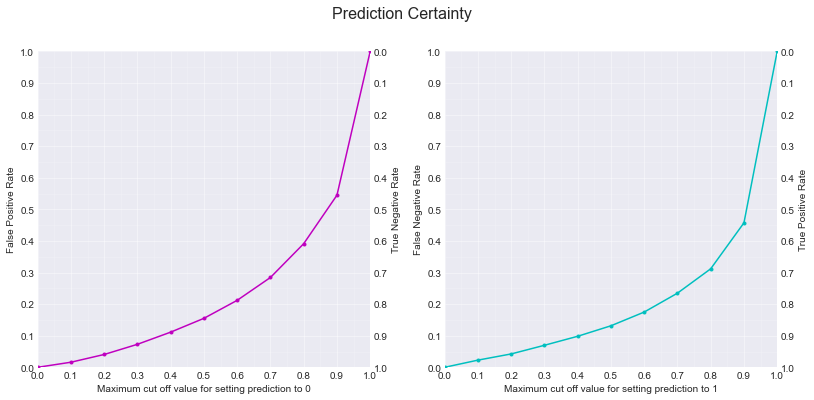

In [94]:
glm_base_prediction_certainty = prediction_certainty(y_test_base, glm_base_clf_final.predict_proba(X_test_base))
glm_base_prediction_certainty

## 4.2 Stacking Base Learner - XGBoost

In [95]:
# restore the base model train and test sets for XGBoost modeling 
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=RANDOM_STATE, stratify=y_base, shuffle=True)

In [96]:
# set the parameters
params = {
    'booster' : 'gbtree', 
    'objective' : 'binary:logistic', 
    'eval_metric': 'logloss', 
    'seed': RANDOM_STATE }

In [97]:
# create the first XGBoost base model
xgb_base_1 = xgb_model(params = params, Xtrain = X_train_base, ytrain = y_train_base, Xtest = X_test_base, ytest = y_test_base)
# the AUC and the classifier from the first XGBoost model
xgb_base_auc_1 = xgb_base_1[0]
xgb_base_clf_1 = xgb_base_1[1]

In [98]:
print(f'AUC: {xgb_base_auc_1}')

AUC: 0.98244


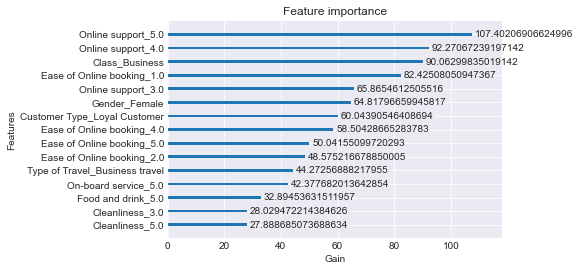

In [99]:
# importance plot showing the 15 features with the highest gain score 
xgb.plot_importance(xgb_base_clf_1, max_num_features=15, importance_type = 'gain', xlabel='Gain')
plt.show()

In [100]:
# Array with the gain scores (feature names not displayed)
np.array(sorted(xgb_base_clf_1.get_booster().get_score(importance_type='gain').values(),reverse=True))

array([107.40206907,  92.27067239,  90.06299835,  82.42508051,
        65.86546125,  64.8179666 ,  60.04390546,  58.50428665,
        50.041551  ,  48.57521668,  44.27256888,  42.37768201,
        32.89453632,  28.02947221,  27.88868507,  24.40986442,
        24.32991884,  20.36841929,  19.51534768,  19.33760011,
        17.04999754,  16.52384664,  15.32695278,  13.14323807,
        12.63060152,  12.63048157,  10.24905588,   9.23440636,
         8.92680391,   8.75754434,   8.54800616,   8.38759183,
         8.21993405,   7.73683224,   7.13984013,   6.87555428,
         6.26660241,   6.23496275,   6.20703091,   5.99193094,
         5.23320044,   5.06758765,   5.00468097,   4.6095424 ,
         4.51101007,   4.43944944,   4.09504324,   4.02933772,
         4.02776959,   3.65025067,   3.5778729 ,   3.54518507,
         3.33720704,   3.31497833,   3.29728346,   3.13839503,
         3.1192332 ,   3.0906516 ,   3.01102685,   2.95459053,
         2.92113757,   2.91369308,   2.90827349,   2.89

In [101]:
# the feature names of the features I keep, and their corresponding gain score
sorted(xgb_base_clf_1.get_booster().get_score(importance_type='gain').items(), key=lambda item: item[1], reverse=True)[:45]

[('Online support_5.0', 107.40206906624996),
 ('Online support_4.0', 92.27067239197142),
 ('Class_Business', 90.06299835019142),
 ('Ease of Online booking_1.0', 82.42508050947367),
 ('Online support_3.0', 65.8654612505516),
 ('Gender_Female', 64.81796659945817),
 ('Customer Type_Loyal Customer', 60.04390546408694),
 ('Ease of Online booking_4.0', 58.50428665283783),
 ('Ease of Online booking_5.0', 50.04155099720293),
 ('Ease of Online booking_2.0', 48.575216678850005),
 ('Type of Travel_Business travel', 44.27256888217955),
 ('On-board service_5.0', 42.377682013642854),
 ('Food and drink_5.0', 32.89453631511957),
 ('Cleanliness_3.0', 28.029472214384626),
 ('Cleanliness_5.0', 27.888685073688634),
 ('Online boarding_2.0', 24.409864420727263),
 ('Food and drink_4.0', 24.329918838438676),
 ('Checkin service_5.0', 20.36841928568627),
 ('Baggage handling_5', 19.515347675951222),
 ('Online boarding_5.0', 19.33760010645833),
 ('Leg room service_5.0', 17.04999754209575),
 ('Inflight wifi servic

In [102]:
# get the gain scores from clf_xgb_base_1, sort in descending order, and subset the top 45 features
gain_score_base = xgb_base_clf_1.get_booster().get_score(importance_type='gain')
gain_score_base_df = pd.DataFrame.from_dict(gain_score_base, orient='index', columns = ['gain']).gain.sort_values(ascending=False)
features_keep_base = gain_score_base_df.iloc[:45]

In [103]:
# keep only the features with the top 60.8 % highest gain scores 
X_train_base = X_train_base.loc[:,X_train_base.columns.isin(features_keep_base.index)]
X_test_base = X_test_base.loc[:,X_test_base.columns.isin(features_keep_base.index)]

### Comment - Base learner - XGBoost
Having completed the feature selection, the same steps as for the first model xgb_base_1 is now done on a new classifier xgb_base_2. I also compare the two models AUC score.

In [104]:
# create the second XGBoost base model
xgb_base_2 = xgb_model(params = params, Xtrain = X_train_base, ytrain = y_train_base, Xtest = X_test_base, ytest = y_test_base)
# the AUC and the classifier from the second XGBoost model
xgb_base_auc_2 = xgb_base_2[0]
xgb_base_clf_2 = xgb_base_2[1]

In [105]:
print(f'AUC: {xgb_base_auc_2}')

AUC: 0.98239


### 4.2.1 Compare AUC, Base learner - XGBoost

The contribution from the other features with low gain score made little difference to the projects main evaluation metric AUC since it’s still on 0.98, the AUC score is very similar for the two models but the model xgb_base_2 is faster when the classifier xgb_base_clf_2 only use 60 % of the original features.  

In [106]:
print(f'AUC xgb_base_2: {xgb_base_auc_2}')
print(f'AUC xgb_base_1: {xgb_base_auc_1}')

AUC xgb_base_2: 0.98239
AUC xgb_base_1: 0.98244


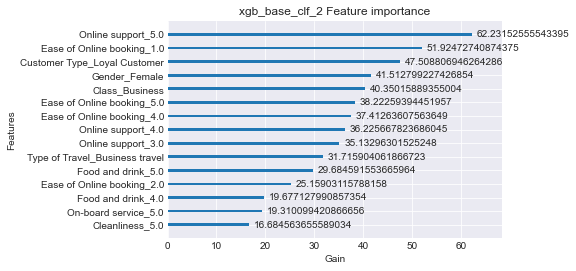

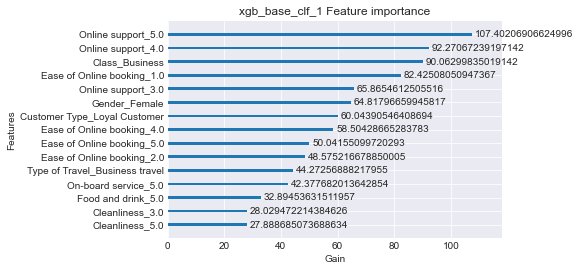

In [107]:
# importance plot showing the 15 features with the highest gain score 
xgb.plot_importance(xgb_base_clf_2, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_base_clf_2 Feature importance')
plt.show()
xgb.plot_importance(xgb_base_clf_1, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_base_clf_1 Feature importance')
plt.show()

### 4.2.2 XGBoost Base learner hyperparameter tuning with Bayesian optimization
I have run the Bayesian optimization and assigned the optimised values to params_tuned_base. I put the code between quotation marks after that, because the Bayesian optimizer takes about 30 minutes to run on a computer with:

* Processor: Intel® Core™ i5 10600k 4,8GHZ 
* Graphic card: Nvidia Geforce RTX2060 6GB (OC-version)
* RAM: 16GB DDR4 2666MHz 

I have created a copy of params_tuned_base so the rest of the project will still run smoothly and saved the output from the Bayesian optimizer in a separate xlsx file ‘bayesian_optimization_iterations.xlsx’ that you can download from my repository. 

If you want to test the Bayesian optimization anyway, remove the quotation marks and delete the cell containing the copy of params_tuned.

In [108]:
def XGbcv(eta, lambda_bo, alpha, max_depth, gamma, min_child_weight, colsample_bytree):
    LOGLOSSbest = 1.
    ITERbest = 0

    paramt = {
              'booster' : 'gbtree',
              'objective': 'binary:logistic',
              'eval_metric': 'logloss',
              'seed' : RANDOM_STATE,
              'eta' : eta, # learning rate
              'lambda' : lambda_bo, # L2 regularization term 
              'alpha' : alpha, # L1 regularization term
              'max_depth' : max_depth.astype(int), # max depth of the trees
              'gamma' : gamma, # pruning of the trees
              'min_child_weight' : min_child_weight, # min number of observations in each leaf
              'colsample_bytree' : colsample_bytree # ratio of variables to choose from in each split
              }

    xgbc = xgb.cv(
           params = paramt,
           dtrain = dtrain_base,
           num_boost_round = xgb_base_clf_2.n_estimators,
           nfold = 5,
           verbose_eval = False,
           early_stopping_rounds = 10,
           seed=RANDOM_STATE,
           shuffle=False
          )

    cv_score = xgbc['test-logloss-mean'].iloc[-1]
    if ( cv_score < LOGLOSSbest ):
        LOGLOSSbest = cv_score
        ITERbest = len(xgbc)

    return (-1.0 * cv_score)

In [109]:
"""dtrain_base = xgb.DMatrix(X_train_base, y_train_base)

print("# Global Optimization Search for XGBoost Parameters")
print("\n Please note that negative Log Loss values will be shown below. This is because")
print(" Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.\n")

XGbBO = BayesianOptimization(XGbcv, {'max_depth': (8, 12),
                                     'gamma': (0.01, 0.6),
                                     'min_child_weight': (1, 6),
                                     'colsample_bytree' :(0.6, 1),
                                     'eta' :(0.1, 0.45),
                                     'lambda_bo': (0, 1),
                                     'alpha': (0.7, 1)}, 
                                     random_state = RANDOM_STATE)

XGbBO.maximize(init_points=25, n_iter=575, acq="ucb", kappa = 2.85, kappa_decay = 0.999, kappa_decay_delay = 50)
print("-" * 53)

best_LOGLOSS = round((-1.0 * XGbBO.max['target']), 6)
alpha = round(XGbBO.max['params']['alpha'], 6)
colsample_bytree = round(XGbBO.max['params']['colsample_bytree'], 6)
eta = round(XGbBO.max['params']['eta'], 6)
gamma = round(XGbBO.max['params']['gamma'], 6)
lambda_bo = round(XGbBO.max['params']['lambda_bo'], 6)
max_depth = round(XGbBO.max['params']['max_depth'])
min_child_weight = round(XGbBO.max['params']['min_child_weight'], 6)

print("\n Best Log Loss value: %f" % best_LOGLOSS)
print(" Best XGBoost parameters:")
print(" max_depth=%d, gamma=%f, min_child_weight=%f, colsample_bytree=%f, eta=%f, lambda_bo=%f, alpha=%f" % (int(max_depth), gamma, min_child_weight, colsample_bytree, eta, lambda_bo, alpha))"""

'dtrain_base = xgb.DMatrix(X_train_base, y_train_base)\n\nprint("# Global Optimization Search for XGBoost Parameters")\nprint("\n Please note that negative Log Loss values will be shown below. This is because")\nprint(" Log Loss needs to be minimized, while the Bayesian Optimizer always maximizes the function.\n")\n\nXGbBO = BayesianOptimization(XGbcv, {\'max_depth\': (8, 12),\n                                     \'gamma\': (0.01, 0.6),\n                                     \'min_child_weight\': (1, 6),\n                                     \'colsample_bytree\' :(0.6, 1),\n                                     \'eta\' :(0.1, 0.45),\n                                     \'lambda_bo\': (0, 1),\n                                     \'alpha\': (0.7, 1)}, \n                                     random_state = RANDOM_STATE)\n\nXGbBO.maximize(init_points=25, n_iter=575, acq="ucb", kappa = 2.85, kappa_decay = 0.999, kappa_decay_delay = 50)\nprint("-" * 53)\n\nbest_LOGLOSS = round((-1.0 * XGbBO.

In [110]:
# from the iteration with 'Best Log Loss value' set parameters to their optimal estimated values 
"""params_tuned_base = {
    'booster' : 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed' : RANDOM_STATE,
    'learning_rate' : eta,
    'reg_lambda' : lambda_bo,
    'reg_alpha' : alpha,
    'max_depth' : max_depth,
    'gamma' : gamma,
    'min_child_weight' : min_child_weight,
    'colsample_bytree' : colsample_bytree
    }

params_tuned_base"""

"params_tuned_base = {\n    'booster' : 'gbtree',\n    'objective': 'binary:logistic',\n    'eval_metric': 'logloss',\n    'seed' : RANDOM_STATE,\n    'learning_rate' : eta,\n    'reg_lambda' : lambda_bo,\n    'reg_alpha' : alpha,\n    'max_depth' : max_depth,\n    'gamma' : gamma,\n    'min_child_weight' : min_child_weight,\n    'colsample_bytree' : colsample_bytree\n    }\n\nparams_tuned_base"

In [111]:
# copy of params_tuned_base, use it when Bayesian optimization isn't used
params_tuned_base = {'booster': 'gbtree',
 'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'seed': RANDOM_STATE,
 'learning_rate': 0.113188,
 'reg_lambda': 0.317478,
 'reg_alpha': 0.928608,
 'max_depth': 11,
 'gamma': 0.590301,
 'min_child_weight': 1.760485,
 'colsample_bytree': 0.677285}

In [112]:
"""
This function is similar to the xgb_tuned_model function with the exemption that the optimized hyperparameter values 
for the classifier instance have been changed. 
The function returns the classifiers rounded AUC score and the classifier. 
"""
def xgb_base_tuned_model(params, Xtrain, ytrain, Xtest, ytest):
    # cast the train partition to dmatrix
    dmatrix = xgb.DMatrix(Xtrain, ytrain)
    # preform a cross-validation to approximate the preferable n_estimator (optimal number of boosting rounds) for the XGBoost classifier
    xgb_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=5, num_boost_round=500, early_stopping_rounds=10, verbose_eval=0, seed=RANDOM_STATE, shuffle=False)
    # get the the best iteration (lowest test log loss) from xgb_cv_1, it will be used as the number of boosting rounds in the classifier
    iter_best = len(xgb_cv)
    # create a XGBClassifer instance and train the model. 
    xgb_clf = xgb.XGBClassifier(n_estimators=iter_best, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss',
    learning_rate=0.113188, reg_lambda=0.317478, reg_alpha=0.928608, max_depth=11, gamma=0.590301, min_child_weight=1.760485, colsample_bytree=0.677285).fit(Xtrain, ytrain)
    # ROC and AUC
    xgb_fpr, xgb_tpr, xgb_threshold = metrics.roc_curve(ytest, xgb_clf.predict_proba(Xtest)[:,1]) 
    xgb_auc = metrics.auc(xgb_fpr, xgb_tpr)

    return np.round(xgb_auc,5), xgb_clf

In [113]:
# create the final XGBoost base model
xgb_base_final = xgb_base_tuned_model(params = params_tuned_base, Xtrain = X_train_base, ytrain = y_train_base, Xtest = X_test_base, ytest = y_test_base)
# the AUC and the classifier from the xgb_base_final
xgb_base_auc_final = xgb_base_final[0]
xgb_base_clf_final = xgb_base_final[1]

In [114]:
print(f'AUC: {xgb_base_auc_final}')

AUC: 0.98332


### 4.2.3 Compare AUC, Base learner - XGBoost hyperparameter tuned

There is a slightly difference regarding the AUC for the tuned model xgb_base_final  and non-tuned xgb_base_2. 

But the hyperparameter tuned classifier xgb_base_clf_final have a higher AUC score (on the same number of features) 

In [115]:
# compare the the tuned and non-tuned classifiers AUC 
print(f'AUC xgb_base_final: {xgb_base_auc_final}')
print(f'AUC xgb_base_2:     {xgb_base_auc_2}')

AUC xgb_base_final: 0.98332
AUC xgb_base_2:     0.98239


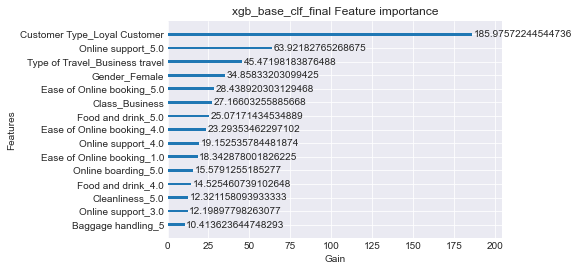

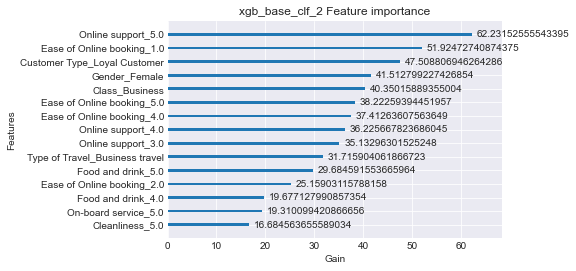

In [116]:
# importance plot showing the 15 features with the highest gain score 
xgb.plot_importance(xgb_base_clf_final, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_base_clf_final Feature importance')
plt.show()
xgb.plot_importance(xgb_base_clf_2, max_num_features=15, importance_type = 'gain', xlabel='Gain', title='xgb_base_clf_2 Feature importance')
plt.show()

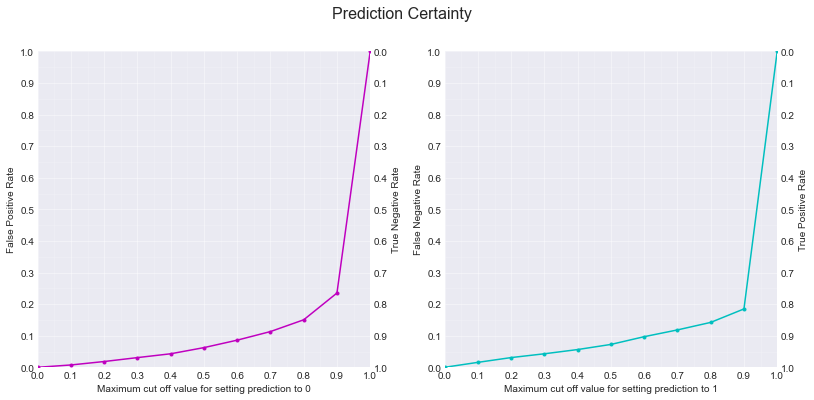

In [117]:
xgb_base_prediction_certainty = prediction_certainty(y_test_base, xgb_base_clf_final.predict_proba(X_test_base))
xgb_base_prediction_certainty

## 4.3 Stacking Meta Learner - Neural network (Keras and TensorFlow)
The creation of the two base learner models are now done and it’s time to create the meta learner that this time going to be a neural network built with help of Keras (a library built on top of TensorFlow). I’m especially going to use Keras flexible <i>Keras Functional API.</i> but I also for example use Keras <i>KerasTurner</i> for the hyperparameter tuning. The steps for doing that is roughly as follows:

1. Use the dataframe for the meta learner (df_meta) to get the probabilities from the two base learners and assign the probabilities from each base learner back to the df_meta dataframe.

2. In this part I describe - Layers - Activation functions (incl ReLU) - Batch normalization - Neural network model instantiation:<br>Create the neural network model with an input layer of shape of 76 (i.e. number of features in df_meta). The model has 4 dense layers, 3 hidden and an output layer. The input layer usually doesn't count as a layer because it has no parameter (weights + bias). The first hidden layer has a dimensionality of the output space set to 128 but the other two hidden layers it’s set to 64. Since the data is divided into 76 features, I want to avoid creating information bottlenecks if I make the intermediate layer too small, hence it’s set to 128.<br>The activation function is used to access a much richer hypothesis space that will benefit from deep representations, without an activation function would a layer only learn linear transformations from a hypothesis space of the input data, in my case a 76-dimensional space. Another important matter is that adding layers wouldn’t extend the hypothesis space i.e. no benefit from multiple layers, because a deep stack of linear layers would still implement a linear operation. Hence the activation is also called non-linearity and the ReLU function that I use for my 3 hidden layers is a popular non-linear activation function because it doesn't activate all the neurons at the same time. The ReLU activation function is a simple calculation that returns the value provided as input directly if it’s positive, or the value 0.0 if the input is 0.0 or less. The function is linear for values greater than zero yet it’s a nonlinear function since negative values are always output as zero. This means that the neurons will only be deactivated if the output of the transformation is less than 0. Since only a certain number of neurons are activated, the ReLU function is far more computationally efficient than several other activation functions. 
<br>The output function has units set to 1 and a sigmoid function as activation function, the same way my logistic function for the regular model and the base learner use a logistic function which also is a sigmoid function. Sigmoid transforms the values between the range 0 and 1, where a value less than 0.5 is predicted as belonging to class 0 and a value over 0.5 is predicted to belong to class 1.<br>Between the dense layers I use a batch normalization layer. Batch normalization is a technique for training neural networks that standardise the inputs to maintain the mean output close to 0 and the output standard deviation close to 1. This has the effect of offering regularization and stabilising the learning process and dramatically reducing the number of training epochs required to train neural networks.<br>Finally I instantiate the model and compile it by setting binary_crossentropy as loss function which is standard for binary classification and it computes the loss between true labels and predicted labels. Adam optimization as the optimizer, it’s a stochastic gradient descent method that among other things is good for sparse data. Accuracy that the metrics to be evaluated by the model during training and testing together with the log loss.  
<br>
3. From X_train_meta and y_train_meta create training and validation sets to be used with the first model nn_1_val. Use early_stopping with patience = 10 and min validation log loss as the objective to monitor. Restore the best model weights from the epoch with the best validation log loss value. Plot the training and validation log loss per epoch.


4. Evaluate the nn_1_val model with the test set. Togheter with confusion matrix, prediction certainty, ROC and AUC.


5. Create a new model nn_1 with epochs set from the early stopping from nn_1_val. This time use all training data i.e. X_train_meta and y_train_meta on the nn_1 neural network model. Evaluate nn_1 with X_test_meta and y_test_meta and also plot the model to even further illustrate how this neural network is built. 


6. Do a hyperparameter tuning to find the optimal number of units i.e. dimensionality of the output space for the dense layers that have ReLU as activation function. Also tune the learning rate for the Adam optimizer. I use Bayesian optimization for the hyperparameter tuning but this time with help of the KerasTuner. KerasTuner is an easy-to-use, scalable hyperparameter optimization framework and I save the results in a json file and also print out the optimal hyperparameter values when the hyperparameter configuration is completed.    


7. Check epochs together with the optimal hyperparameter values. The number of epochs used in the hyperparameter tuning is taken from the nn_1_val model where I used early stopping with a patience of 10 to get the optimal number of epochs, in this case the optimal number of epochs is 6. To control that a model with the optimal  hyperparameter tuning values does not yield an even lower loss value on a notably different number of epochs e.g. in the hundreds. I create a new model with the values from the hyperparameter tuning, train it on the training and validation set from X_train_meta and y_train_meta I created earlier. Use early stopping (monitor the validation loss) with a patience of 10 to get the optimal number of epochs. It turns out that 6 once again is the optimal number of epochs also for the model with the optimal hyperparameter values.


8. Create a new model nn_final with values from the best hyperparameter tuning model and epochs from nn_1_val. Train with the X_train_meta and y_train_meta then  evaluate nn_final with X_test_meta and y_test_meta and compare it to the nn_1 through different evaluation metrics like confusion metric and of course AUC.


In [118]:
# get df_meta probabilities from glm_base_final model
glm_meta_probas = df_meta.drop('Satisfaction', axis=1)
glm_meta_probas = glm_meta_probas.loc[:,rfecv_base.support_]
glm_meta_probas = glm_base_clf_final.predict_proba(glm_meta_probas)[:,1]

In [119]:
# get df_meta probabilities from the xgb_base_final model
xgb_meta_probas = df_meta.drop('Satisfaction', axis=1)
xgb_meta_probas = xgb_meta_probas.loc[:,features_keep_base.index]
xgb_meta_probas = xgb_base_clf_final.predict_proba(xgb_meta_probas)[:,1]

In [120]:
# assign the probabilities from glm_meta_probas and xgb_meta_probas to the df_meta dataframe
df_meta = df_meta.assign(glm_proba=glm_meta_probas, xgb_proba=xgb_meta_probas)

In [121]:
# create the predict and target variables for the meta learners
y_meta = df_meta.Satisfaction
X_meta = df_meta.drop('Satisfaction', axis=1)

# create train and test set
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2, random_state=RANDOM_STATE, stratify=y_meta, shuffle=True)

In [122]:
# Create the neural net model
def neural_net_model():

    x_in = layers.Input(shape=(len(X_train_meta.columns),)) # shape=76
    x = layers.Dense(128, activation='relu')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x_out = layers.Dense(1, activation='sigmoid')(x)

    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    return nn

In [123]:
# Create train and validation sets from X_train_meta and y_train_meta 
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train_meta, y_train_meta, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_meta, shuffle=True)

In [124]:
# Create the first model with early stopping after 10 epochs based on the loss value of the validation set 
tf.random.set_seed(RANDOM_STATE)
nn_1_val = neural_net_model()
nn_1_val.summary() # prints a string summary of the network
history_nn_1_val = nn_1_val.fit(X_train_nn, y_train_nn, batch_size=32, epochs=500, verbose=1, callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=10 , restore_best_weights=True), validation_data=(X_valid_nn, y_valid_nn))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               9856      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256   

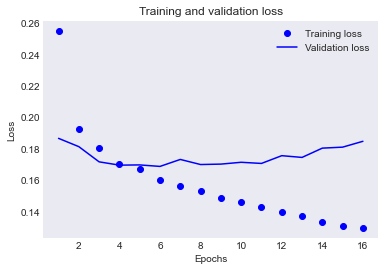

In [125]:
# plot training and validation loss from nn_1_val model
history_nn_1_val_dict = history_nn_1_val.history
loss_values = history_nn_1_val_dict["loss"]
val_loss_values = history_nn_1_val_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [126]:
# Get the number of epochs with the lowest validation log loss
epochs_val_loss = {}
for k , l  in enumerate(history_nn_1_val_dict["val_loss"], 1):
    epochs_val_loss[k] = l


nn_1_val_epochs = (min(epochs_val_loss, key=epochs_val_loss.get)) # key=epochs_val_loss.get means it will be sorted by values of the dictionary
print(nn_1_val_epochs)

6


In [127]:
# evaluate the nn_1_val model with the test set
nn_1_val_results = nn_1_val.evaluate(X_test_meta, y_test_meta)
nn_1_val_results

515/515 [==============================] - 0s 357us/step - loss: 0.1714 - accuracy: 0.9311


[0.17144089937210083, 0.9310973286628723]

In [128]:
# Get the predictions from nn_val_1 based on the test set
nn_1_val_preds = nn_1_val.predict(X_test_meta)

[[7145  475]
 [ 659 8179]]


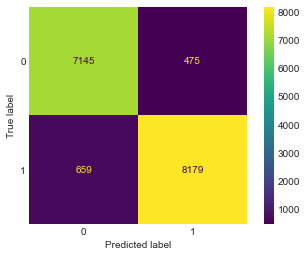

In [129]:
# Print and plot nn_val_1 confusion matrix 
cm_1_val = metrics.confusion_matrix(y_test_meta, nn_1_val_preds > 0.5).astype("int32")
disp_1_val = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_1_val)
print(cm_1_val)
disp_1_val.plot()
plt.show()

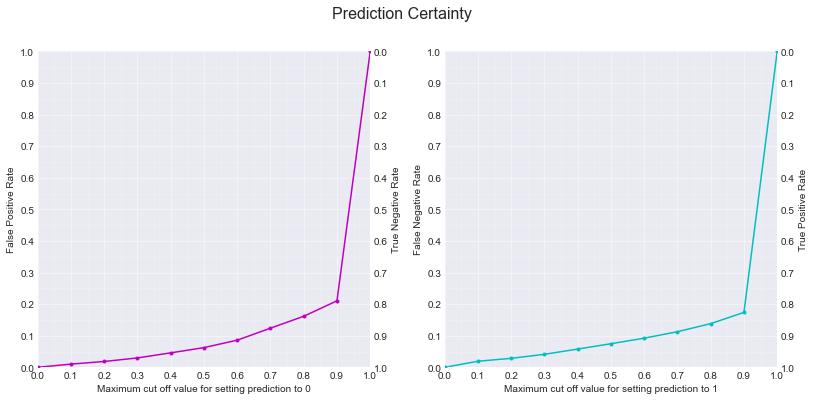

In [130]:
nn_1_val_prediction_certainty = prediction_certainty(y_test_meta, np.concatenate((1-nn_1_val_preds, nn_1_val_preds), axis=1))
nn_1_val_prediction_certainty

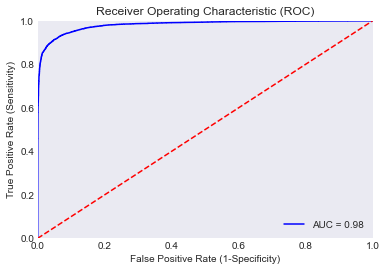

In [131]:
# plot ROC and AUC
nn_1_val_fpr, nn_1_val_tpr, nn_1_val_threshold = metrics.roc_curve(y_test_meta, nn_1_val_preds) 
nn_1_val_auc = metrics.auc(nn_1_val_fpr, nn_1_val_tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(nn_1_val_fpr, nn_1_val_tpr, 'b', label='AUC = %0.2f' % nn_1_val_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

In [132]:
print(f'AUC: {round(nn_1_val_auc,4)}')

AUC: 0.9816


#### New model fit on all training data and epochs from early stopping from nn_1_val model

In [133]:
# clear model session to better illustrate the model structure with 'keras.utils.plot_model()' further down the notebook 
tf.keras.backend.clear_session()

In [134]:
# yet another way to get the optimal number of epochs from nn_1_val and use as number of epochs in the nn_1 model
epochs = len(history_nn_1_val_dict['loss']) - 10 # subtract with 10 beacuse I used patience = 10 in nn_1_val
epochs

6

In [135]:
# create the second model train it on the full X_train_meta and y_train_meta set and epochs is set to the optimal epochs from nn_1_val 
tf.random.set_seed(RANDOM_STATE)
nn_1 = neural_net_model()
nn_1.summary()
nn_1.fit(X_train_meta, y_train_meta, batch_size=32, epochs=epochs, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               9856      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256   

In [136]:
# evaluate the nn_1 model on the test set
nn_1_results = nn_1.evaluate(X_test_meta, y_test_meta)
nn_1_results

515/515 [==============================] - 0s 356us/step - loss: 0.1675 - accuracy: 0.9338


[0.1674528270959854, 0.9337708353996277]

In [137]:
# compare the evaluate loss and accuracy between nn_1 and nn_val_1
print('nn_1_results:')
print(nn_1.evaluate(X_test_meta, y_test_meta))
print('nn_1_val_results:')
print(nn_1_val.evaluate(X_test_meta, y_test_meta))

nn_1_results:
515/515 [==============================] - 0s 356us/step - loss: 0.1675 - accuracy: 0.9338
[0.1674528270959854, 0.9337708353996277]
nn_1_val_results:
515/515 [==============================] - 0s 375us/step - loss: 0.1714 - accuracy: 0.9311
[0.17144089937210083, 0.9310973286628723]


#### Comment: Loss, Neural networks
The loss on the nn_1 model is lower than on the nn_1_val model when I evaluate the two models with the test set. This is likely due to the fact that the nn_1 model is trained with more data than the nn_1_val model.

In [138]:
# Get the predictions from nn_1 based on the test set
nn_1_preds = nn_1.predict(X_test_meta)

[[7107  513]
 [ 577 8261]]


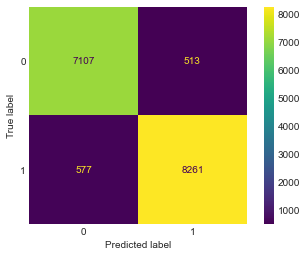

In [139]:
# Print and plot nn_1 confusion matrix 
cm_1 = metrics.confusion_matrix(y_test_meta, nn_1_preds > 0.5).astype("int32")
disp_1 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_1)
print(cm_1)
disp_1.plot()
plt.show()

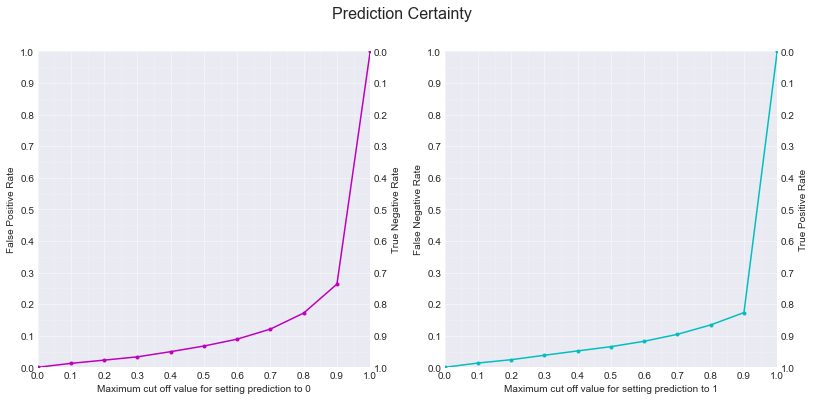

In [140]:
nn_1_prediction_certainty = prediction_certainty(y_test_meta, np.concatenate((1-nn_1_preds, nn_1_preds), axis=1))
nn_1_prediction_certainty

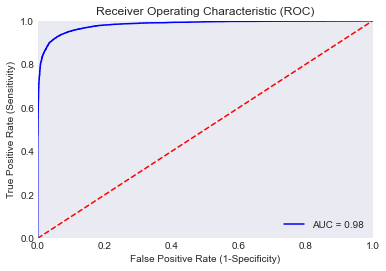

In [141]:
# plot ROC and AUC
nn_1_fpr, nn_1_tpr, nn_1_threshold = metrics.roc_curve(y_test_meta, nn_1_preds) 
nn_1_auc = metrics.auc(nn_1_fpr, nn_1_tpr)

plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(nn_1_fpr, nn_1_tpr, 'b', label='AUC = %0.2f' % nn_1_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

### 4.3.1. Compare AUC, Meta learner - Neural network
The AUC for nn_1 is higher than the AUC for the nn_1_val. This is probably due to the fact that the nn_1 model is trained with more data than the nn_1_val model. 

It’s clear though that the nn_1 model already has a higher AUC score than the standard alone GLM and XGBoost models, as well as the XGBoost meta learner from my previous project. And that is even before the hyperparameter tuning is conducted on this meta learner.   

In [142]:
# compare the two classifiers AUC 
print(f'AUC nn_1:     {round(nn_1_auc,5)}')
print(f'AUC nn_1_val: {round(nn_1_val_auc,5)}')

AUC nn_1:     0.98246
AUC nn_1_val: 0.98162


    * AUC GLM:      0.92607
    * AUC XGBoost:  0.98187
    * AUC XGB Meta: 0.98016 (from previous project)

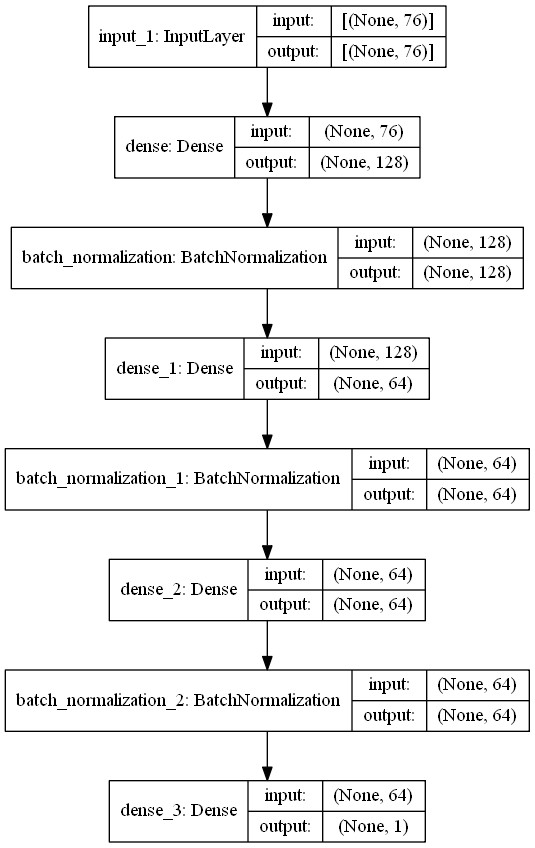

In [143]:
# plot nn_1 to better illustrate the model  
keras.utils.plot_model(nn_1,show_shapes=True)

### 4.3.2. Neural network Meta learner hyperparameter tuning with KerasTuner Bayesian optimization

In [144]:
# create model used for hyperparameter tuning
def neural_net_tune_model(hp):
  # Tune the number of units in the Dense layer
  # The first layer choose an optimal value between 80-512
  # Choose an optimal value between 32-512 for the others  
  hp_units1 = hp.Int('units1', min_value=80, max_value=512, step=16)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=16)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=16)

  x_in = layers.Input(shape=(len(X_train_meta.columns),))
  x = layers.Dense(units=hp_units1, activation='relu')(x_in)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(units=hp_units2, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(units=hp_units3, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x_out = layers.Dense(1, activation='sigmoid')(x)  
  
  # Tune the learning rate for the Adam optimizer
  # Choose an optimal value from 0.0008 to 0.2
  hp_learning_rate = hp.Float('learning_rate', min_value=0.0008, max_value=0.2, sampling="log")

  nn_tune = Model(inputs=x_in, outputs=x_out)
  nn_tune.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])

  return nn_tune

In [145]:
# Use Bayesian optimization for the hyperparameter
tuner = kt.BayesianOptimization(
    hypermodel = neural_net_tune_model,
    objective='val_loss',
    max_trials=600, # 600 hyperparameter tuning search trials
    num_initial_points=25,
    seed = RANDOM_STATE,
    # save the parameters that togheter yields the lowest validation loss 
    directory='keras_tuner_dir', 
    project_name='kt_bo'
)

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir\kt_bo\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_dir\kt_bo\tuner0.json


In [146]:
# print search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 80, 'max_value': 512, 'step': 16, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 16, 'sampling': None}
learning_rate (Float)
{'default': 0.0008, 'conditions': [], 'min_value': 0.0008, 'max_value': 0.2, 'step': None, 'sampling': 'log'}


In [147]:
# search for best hyperparameter configuations use the train and validation set created from X_train_meta and y_train_meta
tuner.search(X_train_nn, y_train_nn, batch_size=32, epochs=epochs, verbose=1, validation_data=(X_valid_nn, y_valid_nn))

Trial 600 Complete [00h 00m 14s]
val_loss: 0.17530283331871033

Best val_loss So Far: 0.16190719604492188
Total elapsed time: 07h 16m 19s
INFO:tensorflow:Oracle triggered exit


In [147]:
# print the best hyperparameter values
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))

units1 496
units2 512
units3 48
learning_rate 0.006206014669498314


#### Check epochs together with the optimal hyperparameter values
The number of epochs used in the hyperparameter tuning is taken from the nn_1_val model where I used early stopping with a patience of 10 to get the optimal number of epochs, in this case the optimal number of epochs is 6. To control that a model with the optimal  hyperparameter tuning values does not yield an even lower loss value on a notably different number of epochs e.g. in the hundreds. I create a new model with the values from the hyperparameter tuning, train it on the training and validation set from X_train_meta and y_train_meta I created earlier. Use early stopping (monitor the validation loss) with a patience of 10 to get the optimal number of epochs. It turns out that 6 once again is the optimal number of epochs also for the model with the optimal hyperparameter values.  

The optimal hyperparameter values:
* units1 496
* units2 512
* units3 48
* learning_rate 0.006206014669498314

In [148]:
# Create the neural net model with the optimal values from the hyperparameter tuning
def hp_values_neural_net_model():

    x_in = layers.Input(shape=(len(X_train_meta.columns),)) # shape=76
    x = layers.Dense(496, activation='relu')(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(48, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x_out = layers.Dense(1, activation='sigmoid')(x)

    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.006206014669498314), metrics=['accuracy'])

    return nn

In [149]:
# Create the model with early stopping after 10 epochs based on the loss value of the validation set 
tf.random.set_seed(RANDOM_STATE)
nn_hp_val = hp_values_neural_net_model()
nn_hp_val.summary() # prints a string summary of the network
history_nn_hp_val = nn_hp_val.fit(X_train_nn, y_train_nn, batch_size=32, epochs=500, verbose=1, callbacks=keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', patience=10 , restore_best_weights=True), validation_data=(X_valid_nn, y_valid_nn))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 76)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 496)               38192     
_________________________________________________________________
batch_normalization_6 (Batch (None, 496)               1984      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               254464    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 48)                24624     
_________________________________________________________________
batch_normalization_8 (Batch (None, 48)                192 

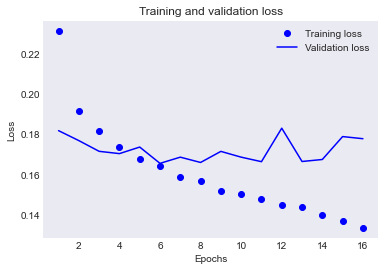

In [150]:
# plot training and validation loss from nn_hp_val model
history_nn_hp_val_dict = history_nn_hp_val.history
hp_loss_values = history_nn_hp_val_dict["loss"]
hp_val_loss_values = history_nn_hp_val_dict["val_loss"]
hp_epochs = range(1, len(hp_loss_values) + 1)
plt.plot(hp_epochs, hp_loss_values, "bo", label="Training loss")
plt.plot(hp_epochs, hp_val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [151]:
# get the optimal number of epochs from nn_hp_val
len(history_nn_hp_val_dict['loss']) - 10 # subtract with 10 beacuse I used patience = 10 in nn_hp_val

6

#### Create a new model nn_final with values from the best hyperparameter tuning model and epochs from nn_1_val

In [152]:
tf.random.set_seed(RANDOM_STATE)
# returns the best hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
# nn_final reinstantiate the best model found during the hyperparameter tuning search process.
nn_final = tuner.hypermodel.build(best_hps)
# train it on the full X_train_meta and y_train_meta set and epochs set to the optimal epochs from nn_1_val 
nn_final.fit(X_train_meta, y_train_meta, batch_size=32, epochs=epochs, verbose=1)

Epoch 1/6
2058/2058 [==============================] - 4s 2ms/step - loss: 0.2689 - accuracy: 0.8893
Epoch 2/6
2058/2058 [==============================] - 3s 2ms/step - loss: 0.1920 - accuracy: 0.9200
Epoch 3/6
2058/2058 [==============================] - 3s 2ms/step - loss: 0.1793 - accuracy: 0.9279
Epoch 4/6
2058/2058 [==============================] - 3s 2ms/step - loss: 0.1715 - accuracy: 0.9296
Epoch 5/6
2058/2058 [==============================] - 3s 2ms/step - loss: 0.1706 - accuracy: 0.9296
Epoch 6/6
2058/2058 [==============================] - 3s 2ms/step - loss: 0.1678 - accuracy: 0.9294


In [153]:
# evaluate the nn_final model on the test set
nn_final.evaluate(X_test_meta, y_test_meta)

515/515 [==============================] - 0s 493us/step - loss: 0.1627 - accuracy: 0.9341


[0.1626756638288498, 0.934135377407074]

In [154]:
# compare the evaluate loss and accuracy between nn_final and nn_1
print('nn_final_results:')
print(nn_final.evaluate(X_test_meta, y_test_meta))
print('nn_1_results:')
print(nn_1.evaluate(X_test_meta, y_test_meta))

nn_final_results:
515/515 [==============================] - 0s 474us/step - loss: 0.1627 - accuracy: 0.9341
[0.1626756638288498, 0.934135377407074]
nn_1_results:
515/515 [==============================] - 0s 357us/step - loss: 0.1675 - accuracy: 0.9338
[0.1674528270959854, 0.9337708353996277]


In [155]:
# Get the predictions from nn_final based on the test set
nn_final_preds = nn_final.predict(X_test_meta)

[[7103  517]
 [ 567 8271]]


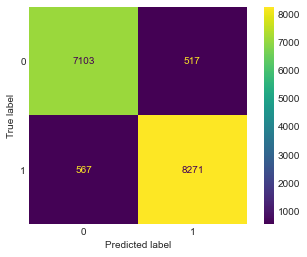

In [156]:
# Print and plot nn_final confusion matrix 
cm_final = metrics.confusion_matrix(y_test_meta, nn_final_preds > 0.5).astype("int32")
disp_final = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_final)
print(cm_final)
disp_final.plot()
plt.show()

nn_final:


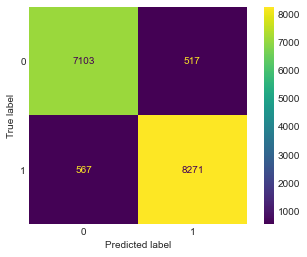

nn_1


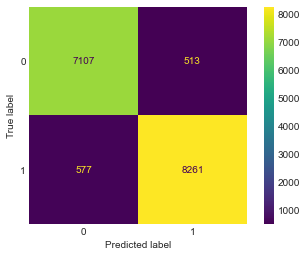

In [157]:
print('nn_final:')
disp_final.plot()
plt.show()
print('nn_1')
disp_1.plot()
plt.show()

In [158]:
metrics.confusion_matrix(y_test_meta, nn_final_preds > 0.5).astype("int32")

array([[7103,  517],
       [ 567, 8271]])

In [159]:
metrics.confusion_matrix(y_test_meta, nn_1_preds > 0.5).astype("int32")

array([[7107,  513],
       [ 577, 8261]])

In [160]:
# plot ROC and AUC
nn_1_fpr, nn_1_tpr, nn_1_threshold = metrics.roc_curve(y_test_meta, nn_1_preds) 
nn_1_auc = metrics.auc(nn_1_fpr, nn_1_tpr)

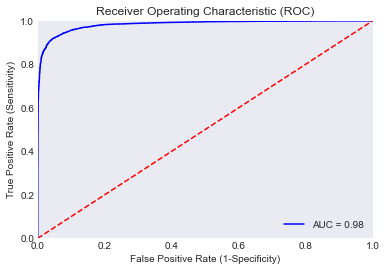

In [161]:
nn_final_fpr, nn_final_tpr, nn_final_threshold = metrics.roc_curve(y_test_meta, nn_final_preds) 
nn_final_auc = metrics.auc(nn_final_fpr, nn_final_tpr)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(nn_final_fpr, nn_final_tpr, 'b', label='AUC = %0.2f' % nn_final_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

### 4.3.3. Compare AUC, Meta learner - Neural network hyperparameter tuned
The AUC for nn_1_final is higher than the AUC for the nn_1, thanks to the hyperparameter tuning I conducted. I choose to use nn_final’s AUC to compare against the other models AUC’s.   

In [162]:
# compare the AUC between nn_final and nn_1 
print(f'AUC nn_final: {round(nn_final_auc,5)}')
print(f'AUC nn_1:     {round(nn_1_auc,5)}')

AUC nn_final: 0.98316
AUC nn_1:     0.98246


# 5. Conclusion -  Comparing AUC
    * AUC GLM:      0.92607
    * AUC XGBoost:  0.98187
    * AUC XGB Meta: 0.98016 (from previous project)
    * AUC NN Meta:  0.98316

My goal of obtaining a higher AUC score for the neural network meta learner than for the XGBoost meta learner from my previous project is achieved. I’m also pleased that I received a higher AUC score with the neural network meta learner than was yielded with both of the standalone GLM and XGBoost models. This goes along with what many research papers conclude, that a stacked generalization of adding predictions from several machine learning models i.e. base learners to a neural network meta learner can improve your end predictions even further.   

### 5.1 A higher AUC score, so what? - Business context
The AUC of the neural network meta learner is higher at 0.98316 than the AUC score of the XGBoost meta learner from my previous project, that AUC score was 0.98016. But chances are that when you present these two AUC scores for a stakeholder it will be difficult for the stakeholder to comprehend that there are any differences at all regarding the two models, most humans would (often unintentionally) round up the score to 1. Hence I suggest that to better explain your model to stakeholders, add false positive and/or false negative rate to your explanation of how well the model performs. It could sound something like this:

“On a daily average our current model predicts that 5 000 of our airline travellers will be neutral/dissatisfied with their flight. Our current model using XGBoost as a meta learner has a false negative rate of 7.46%. Which means that 373 travellers are wrongly predicted to be neutral/dissatisfied with their flight. With the new model I want to deploy, using a neural network as a meta learner. That model has a false negative rate of 6.42%. Which means that 321 travellers are wrongly predicted to be neutral/dissatisfied with their flight. That means that the new model predicts 52 fewer airline travellers as falsely neutral/dissatisfied with their flight and instead they are correctly predicted to be satisfied with their flight.”  

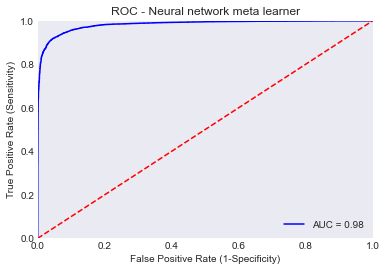

In [195]:
# ROC and AUC good way to show True Positive Rate (Sensitivity) and False Positive Rate (1-Specificity)
plt.title('ROC - Neural network meta learner')
plt.plot(nn_final_fpr, nn_final_tpr, 'b', label='AUC = %0.2f' % nn_final_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.show()

Neural network meta learner:


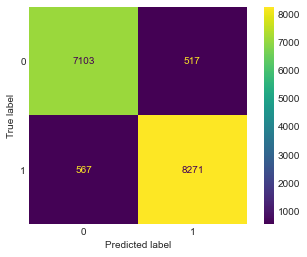

XGBoost meta learner (from previous project):


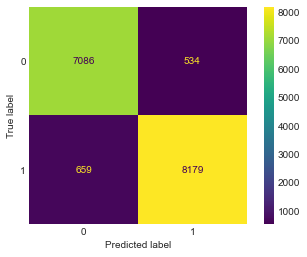

In [196]:
# the confusion matrix for the neural network meta leaner
meta_nn_cm = metrics.confusion_matrix(y_test_meta, nn_final_preds > 0.5).astype("int32")
meta_nn_cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=meta_nn_cm)
print('Neural network meta learner:')
meta_nn_cm_disp.plot()
plt.show()

# the confusion matrix for the XGBoost meta learner (from previous project)
meta_xgb_cm = metrics.confusion_matrix(y_test_meta, (clf_meta_tuned.predict(X_test_meta) > 0.5)).astype("int32")
meta_xgb_cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=meta_xgb_cm)
print('XGBoost meta learner (from previous project):')
meta_xgb_cm_disp.plot()
plt.show()

In [197]:
# the confusion matrix again
print('Neural network meta learner:')
print(meta_nn_cm)
print('XGBoost meta learner (from previous project):')
print(meta_xgb_cm)

Neural network meta learner:
[[7103  517]
 [ 567 8271]]
XGBoost meta learner (from previous project):
[[7086  534]
 [ 659 8179]]


In [198]:
# calculate the false negative rates (FNR) and false postive rate (FPR) 
# I’m doing it this way to be extra obvious regarding the calculation of FNR and FPR, 
# in other cases I would do the calculations in a less “hard coded” fashion      
print(f'NN Meta learner:  {(567/(567+8271))*100:5.2f} % FNR')
print(f'NN Meta learner:  {(517/(7103+517))*100:5.2f} % FPR\n')
print(f'XGB Meta learner: {(659/(659+8179))*100:5.2f} % FNR  (from previous project)')
print(f'XGB Meta learner: {(534/(7086+534))*100:5.2f} % FPR  (from previous project)')

NN Meta learner:   6.42 % FNR
NN Meta learner:   6.78 % FPR

XGB Meta learner:  7.46 % FNR  (from previous project)
XGB Meta learner:  7.01 % FPR  (from previous project)
